# 1 - Imports

In [199]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import random
from IPython.display import Image
from tabulate import tabulate
from pycorrcat.pycorrcat import corr_matrix
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import scikitplot as skplt
from warnings import filterwarnings

In [200]:
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [18, 8]

sns.set;

## 1.1 - Funções

In [201]:
def precision(data, pred, percent):
    '''Contar quantas predições foram corretas até k e dividir por todas as predições realizadas pelo modelo até k.
    data: dataset
    pred: probabilidade medida pelo modelo (predict_proba)
    k: porcentagem do dataset'''
    # Porcentagem
    k=int(len(data)*percent)
    
    # Score
    data['score'] = pred[:, 1].tolist()

    # Ordenando o cliente pelo score
    data = data.sort_values('score', ascending=False)

    # Resetando o index
    data = data.reset_index(drop=True)

    # Criando a ordem do ranking
    data['ranking'] = data.index + 1 
    
    # Calculando a precisão
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def recall(data, pred, percent):
    '''Contar quantos predições foram corretas até k e dividir por todos os exemplos verdadeiros
    data: dataset
    pred: probabilidade medida pelo modelo (predict_proba)
    k: porcentagem do dataset'''
    # Porcentagem
    k=int(len(data)*percent)
    
    # Score
    data['score'] = pred[:, 1].tolist()

    # Ordenando o cliente pelo score
    data = data.sort_values('score', ascending=False)
    
    # Resetando o index
    data = data.reset_index(drop=True)

    # Criando a ordem do ranking
    data['ranking'] = data.index + 1 
    
    # Calculando o Recall
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

def cross_validation(model_name, model, splits, X_train, y_train, percent):
    '''Treinamento do modelo com validação cruzada
    model_name: Nome do modelo (colocar entre aspas para string)
    model: modelo que vai ser utilizado
    split: número de divisões para o treinamento
    X_train: features para treinamento
    y_train: target para o treinamento
    percent: porcentagem do dataset'''
    lista_precision = []
    lista_recall = []
    
    fold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
    
    for train, test in fold.split(X_train, y_train):
        # Treino
        X_train_fold = X_train.iloc[train]
        y_train_fold = y_train.iloc[train]
        
        # Teste
        X_test_fold = X_train.iloc[test]
        y_test_fold = y_train.iloc[test]
        
        # Treinando o modelo
        model_fit = model.fit(X_train_fold, y_train_fold)
        
        # Predict Score
        y_pred = model_fit.predict_proba(X_test_fold)
        
        X_test_fold['response'] = y_test_fold
        
        # Precisão top K
        lista_precision.append(precision(X_test_fold, y_pred, percent))
        lista_recall.append(recall(X_test_fold, y_pred, percent))
        
    # Média das métricas
    mean_precision = np.round(np.mean(lista_precision),2)
    mean_recall = np.round(np.mean(lista_recall),2)
    
    # Desvio padrão das métricas
    std_precision = np.round(np.std(lista_precision),2)
    std_recall = np.round(np.std(lista_recall),2)
    
    precision_top_k = 'mean: ' + mean_precision.astype(str) + ' | ' + 'std: ' + ' +/- ' + std_precision.astype(str)
    recall_top_k = 'mean: ' + mean_recall.astype(str) + ' | ' + 'std: ' + ' +/- ' + std_recall.astype(str)
    
    data = {'model_name': model_name, 'Precision':precision_top_k, 'Recall':recall_top_k}
    df = pd.DataFrame(data, index=[0])
        
    return df

def performance(model_name, y_test, y_pred):
    '''Retorna um dataframe com a performance do modelo
    model_name: nome do modelo
    y_test: coluna alvo
    y_pred: valor do predict_proba de cada modelo'''
    df = pd.DataFrame()
    df['model_name'] = None
    df['response'] = y_test.copy()
    df['prediction'] = y_pred[:,1].tolist()
    df['model_name'] = model_name

    # Ordenando pela coluna prediction
    df.sort_values('prediction', ascending=False, inplace=True)

    # Porcentagem dos interessados (Propensity Score)
    df['cumsum'] = df['response'].cumsum()
    df['cumsum_percent'] = 100*df['cumsum']/df['response'].sum()
    df.head(10)

    # Porcentagem da base de clientes
    df['base'] = range(1, len(df) + 1)
    df['base_percent'] = 100*df['base']/len(df)

    # Curva lift
    df['lift'] = df['cumsum_percent']/df['base_percent']

    # Precisão
    df['precision'] = df['cumsum']/df['base']

    # Recall
    df['recall'] = df['cumsum'] /df['response'].sum()
    
    return df

## 1.2 - Cargando os dados

In [202]:
df = pd.read_csv('../data/train.csv')

In [203]:
df.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,374686,Male,29,50.0,152.0,1,< 1 Year,No,1,57077.0,187,0
1,165999,Male,24,37.0,152.0,1,< 1 Year,No,1,29665.0,135,0
2,132267,Male,33,46.0,26.0,1,1-2 Year,No,1,46675.0,100,0
3,250655,Male,21,8.0,152.0,1,< 1 Year,Yes,0,37365.0,126,0
4,85041,Female,23,27.0,26.0,1,< 1 Year,Yes,0,32549.0,78,0


# 2 - Descrição dos dados

In [204]:
df2 = df.copy()

## 2.1 - Dimensão do dataset

In [205]:
print(f'Quantidade de linhas: {df2.shape[0]}')
print(f'Quantidade de colunas: {df2.shape[1]}')

Quantidade de linhas: 304887
Quantidade de colunas: 12


## 2.2 - Renomear as colunas

In [206]:
new_columns = []
for e in df2.columns:
    new_columns.append(e.lower())

df2.columns = new_columns

## 2.3 - Tipos dos dados

In [207]:
df2.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 2.4 - Dados nulos

In [208]:
df2.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 2.5 - Correção dados nulos

## 2.6 - Alteração dos tipos dos dados

## 2.7 - Análise descritiva

In [209]:
num = df2.select_dtypes(include=['int64', 'float64'])
cat = df2.select_dtypes(exclude=['int64', 'float64'])

### 2.7.1 - Análise numérica

In [210]:
# média, desvio padrão, mínimo, quartis, máximo
desc = num.describe().T
desc.drop('count', axis=1, inplace=True)

# mediana
median = pd.DataFrame(num.apply(np.median))
desc.insert(2,'median', median[0].values)

# range
range_ = pd.DataFrame( num.apply( lambda x: x.max() - x.min() ) )
desc.insert(len(desc.columns),'range', range_[0].values)

# trocando o desvio padrão de posição
std = desc.pop('std')
desc.insert(len(desc.columns),'std', std)

# skewness
skew = pd.DataFrame(num.apply(lambda x: x.skew()))
desc.insert(len(desc.columns),'skew', skew[0].values)

# kurtosis
kurtosis = pd.DataFrame(num.apply(lambda x: x.kurtosis()))
desc.insert(len(desc.columns),'kurtosis', kurtosis[0].values)

# Remover 25%, 50% e 75%
desc.drop(['25%', '50%', '75%'], axis=1, inplace=True)

desc

,mean,median,min,max,range,std,skew,kurtosis
id,190617.780335,190487.0,1.0,381109.0,381108.0,110092.599329,0.000734,-1.201952
age,38.839613,36.0,20.0,85.0,65.0,15.504121,0.669962,-0.568603
region_code,26.398813,28.0,0.0,52.0,52.0,13.224854,-0.115653,-0.865878
policy_sales_channel,111.917091,128.0,1.0,163.0,162.0,54.255170,-0.895108,-0.980265
driving_license,0.997839,1.0,0.0,1.0,1.0,0.046441,-21.439629,457.660678
previously_insured,0.457953,0.0,0.0,1.0,1.0,0.498230,0.168786,-1.971524
annual_premium,30610.417112,31700.0,2630.0,540165.0,537535.0,17250.406527,1.831854,35.674182
vintage,154.280629,154.0,10.0,299.0,289.0,83.692217,0.004262,-1.201686
response,0.122846,0.0,0.0,1.0,1.0,0.328260,2.297914,3.280429


### 2.7.2 - Análise categórica

In [211]:
for x in cat.columns:
    print(f'- A coluna {x} tem {cat[x].unique().shape[0]} valores únicos: {cat[x].unique()}')

- A coluna gender tem 2 valores únicos: ['Male' 'Female']
- A coluna vehicle_age tem 3 valores únicos: ['< 1 Year' '1-2 Year' '> 2 Years']
- A coluna vehicle_damage tem 2 valores únicos: ['No' 'Yes']


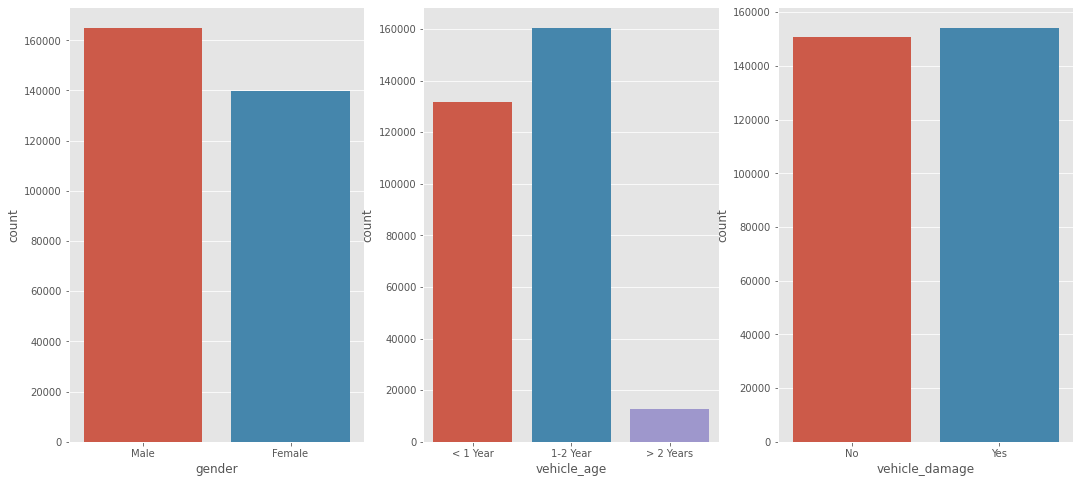

In [212]:
plt.subplot(1, 3, 1)
sns.countplot(x='gender', data=df2)
plt.subplot(1, 3, 2)
sns.countplot(x='vehicle_age', data=df2)
plt.subplot(1, 3, 3)
sns.countplot(x='vehicle_damage',data=df2);

# 3 - Feature engineering

In [213]:
df3 = df2.copy()

## 3.1 - Mapa mental das hipóteses

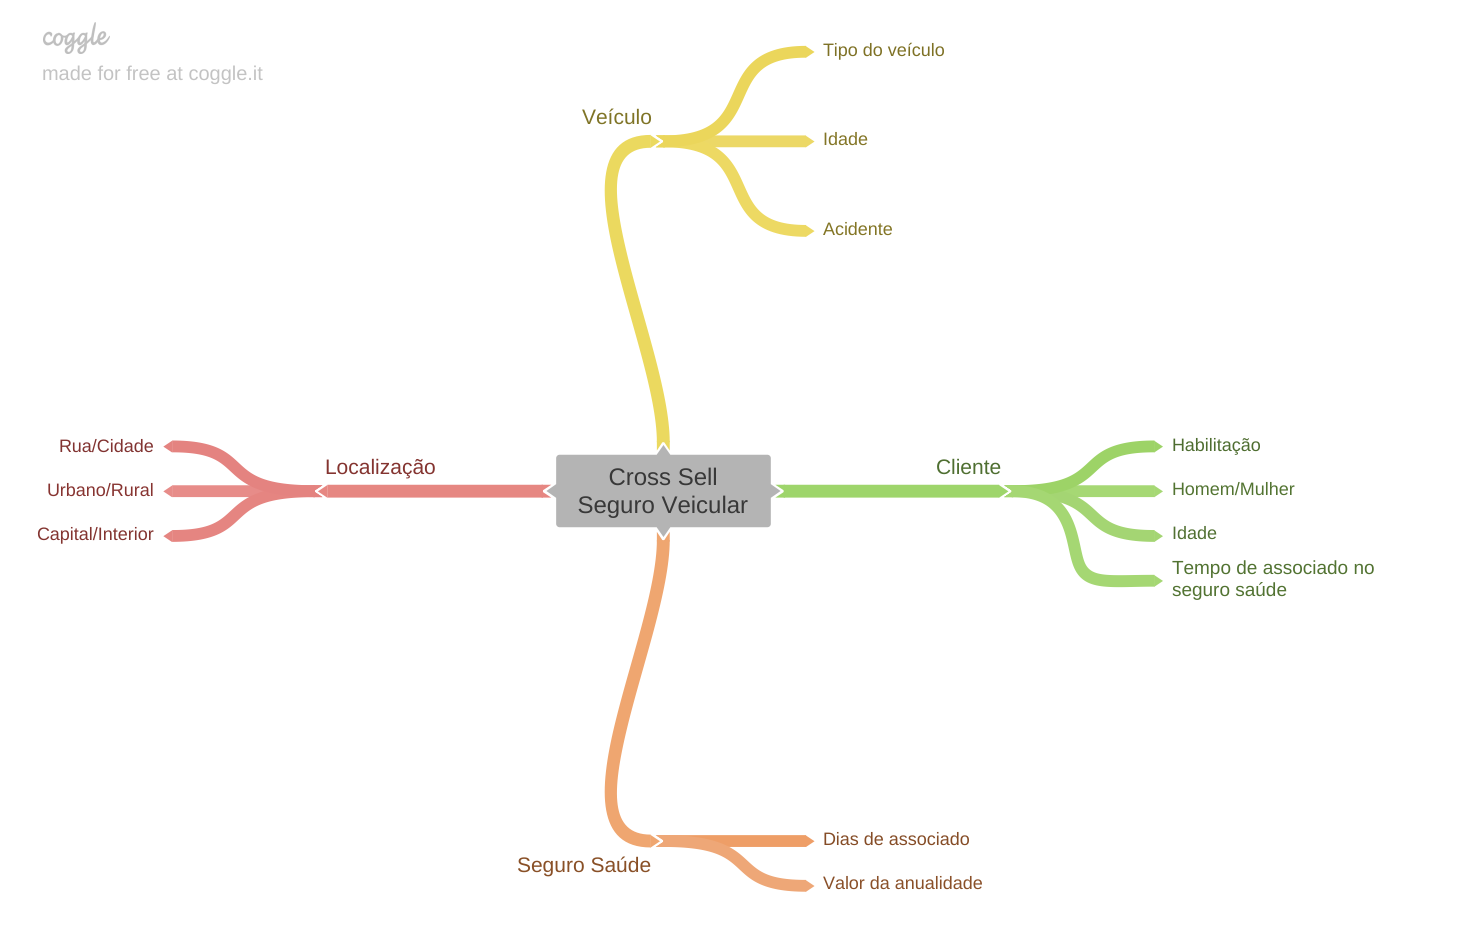

In [214]:
Image('../img/mapa_mental_cross_sell.png')

## 3.2 - Lista das hipóteses

**Gênero/Acidente**  
Hipótese 1 - Homens se acidentam 30% mais que as mulheres.  

**Gênero/Habilitação**  
Hipótese 2 - Há 30% mais homens habilitados do que as mulheres.  

**Gênero/Idade do veículo**  
Hipótese 3 - Mais de 50% das mulheres dirigem carros com menos de 1 ano enquanto mais de 50% dos homens dirigem carros com mais de 2 anos.  

**Gênero/Seguro veicular**    
Hipótese 4 - Mais de 40% de homens e mulheres possuem seguro veicular.  

**Idade/Acidente**  
Hipótese 5 - Pessoas com menos de 40 anos se acidentam 20% mais.  

**Idade/Idade do veículo**  
Hipótese 6 - Mais de 50% pessoas com menos de 40 anos dirigem carros mais novos (com menos de 1 ano), enquanto mais de 40% da pessoas com mais de 40 dirigem carros mais antigos.  
  
**Idade/Seguro veicular**  
Hipótese 7 - Menos de 40% das pessoas com menos de 40 anos dirigem sem seguro no veículo, enquanto mais de 70% das pessoas com mais de 40 anos possuem seguro.  

## 3.4 - Feature engineering

# 4 - Filtragem das variáveis

In [215]:
df4 = df3.copy()

## 4.1 - Seleção das linhas

## 4.2 - Seleção das colunas

# 5 - Análise exploratória dos dados

In [216]:
df5 = df4.copy()

## 5.1 - Análise univariada

### 5.1.1 - Variável resposta

In [217]:
df5['response'].value_counts().reset_index().rename(columns={0:'count'})

,index,response
0,0,267433
1,1,37454


In [218]:
df5['response'].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,index,response
0,0,0.877154
1,1,0.122846


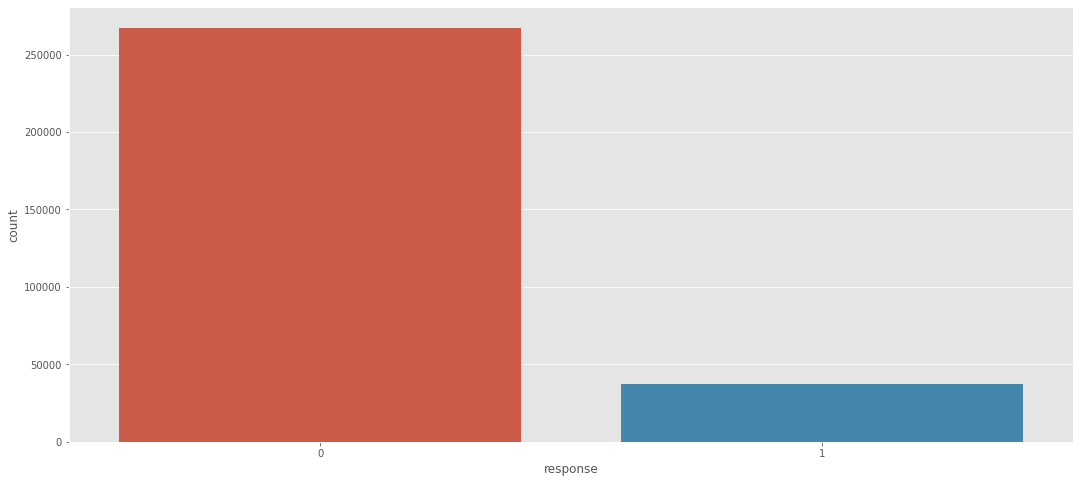

In [219]:
sns.countplot(df5['response']);

### 5.2.1 - Variáveis numéricas

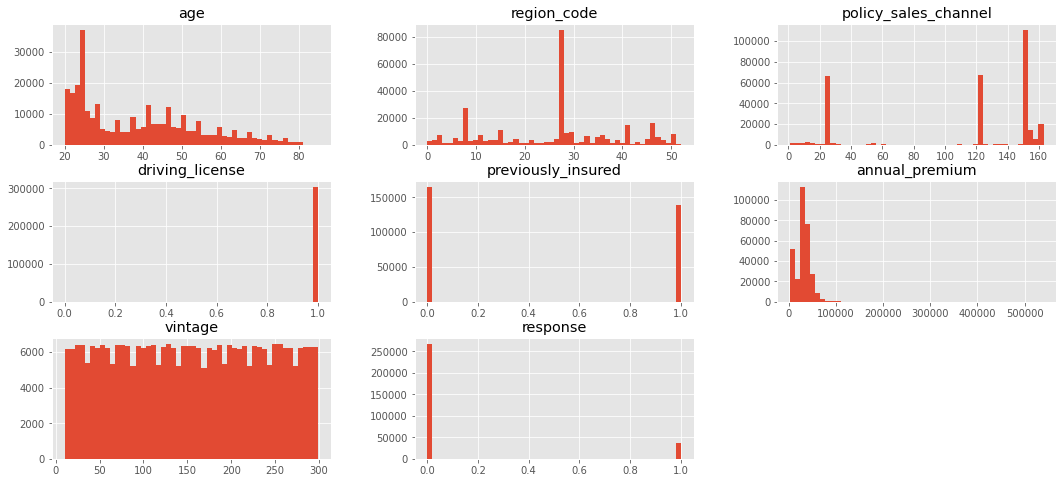

In [220]:
num.drop('id', axis=1).hist(label=num['response'], bins=50);

### 5.1.3 - Variáveis categóricas

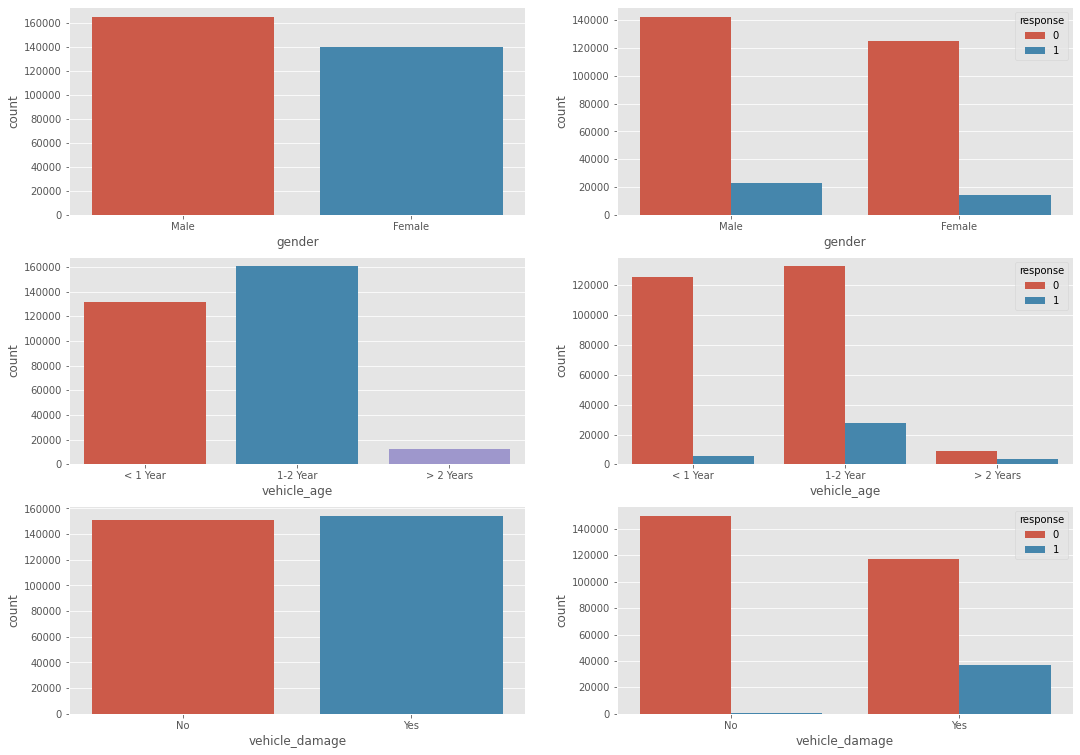

In [221]:
plt.figure(figsize=(18, 13))
plt.subplot(3, 2, 1)
sns.countplot(x='gender', data=df5)

plt.subplot(3, 2, 2)
sns.countplot(x='gender', hue='response', data=df5)

plt.subplot(3, 2, 3)
sns.countplot(x='vehicle_age', data=df5)

plt.subplot(3, 2, 4)
sns.countplot(x='vehicle_age', hue='response', data=df5)

plt.subplot(3, 2, 5)
sns.countplot(x='vehicle_damage', data=df5)

plt.subplot(3, 2, 6)
sns.countplot(x='vehicle_damage', hue='response', data=df5);

### Gender

In [222]:
df5[['gender', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,gender,response,count
0,Male,0,142160
1,Female,0,125273
2,Male,1,22867
3,Female,1,14587


In [223]:
df5[['gender', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,gender,response,percent
0,Male,0,0.466271
1,Female,0,0.410883
2,Male,1,0.075002
3,Female,1,0.047844


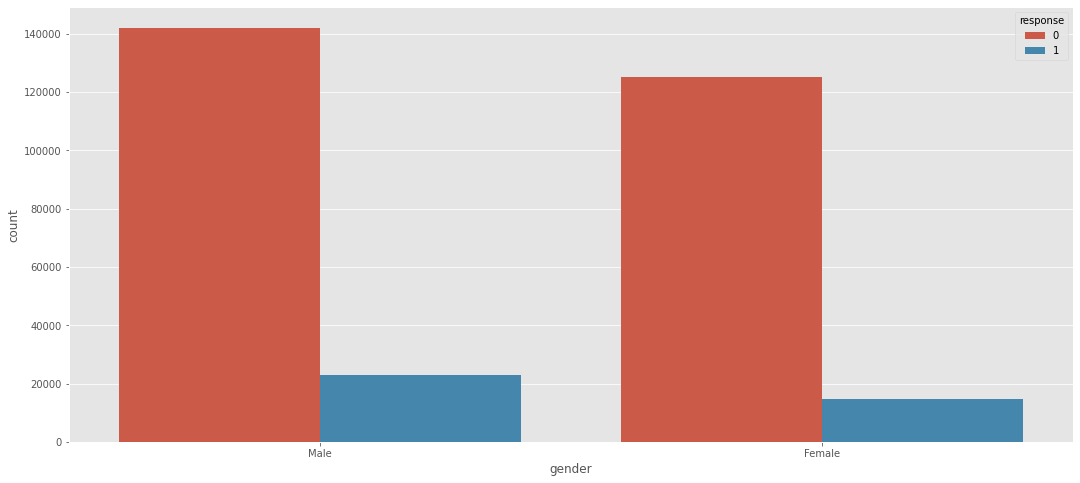

In [224]:
sns.countplot(x='gender', hue='response', data=df5);

### Age

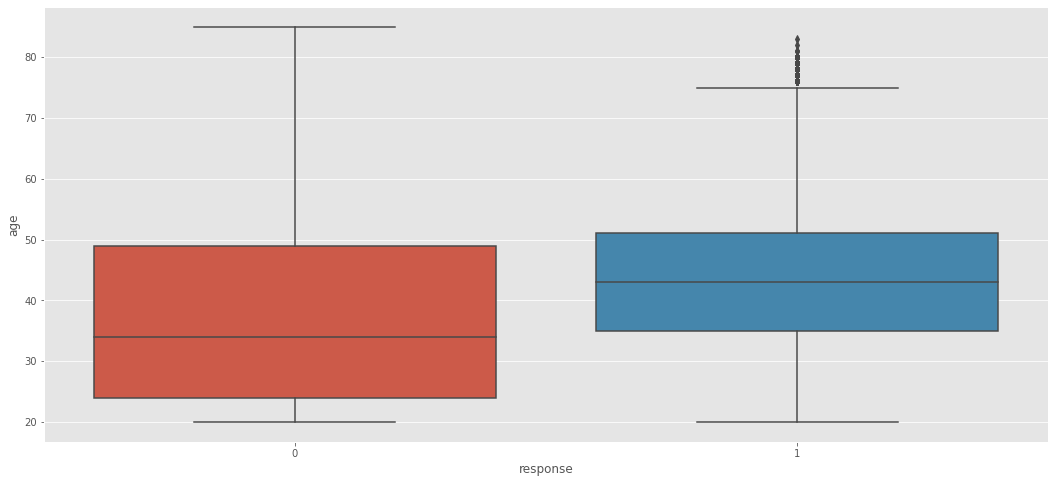

In [225]:
sns.boxplot(x='response', y='age', data=df5);

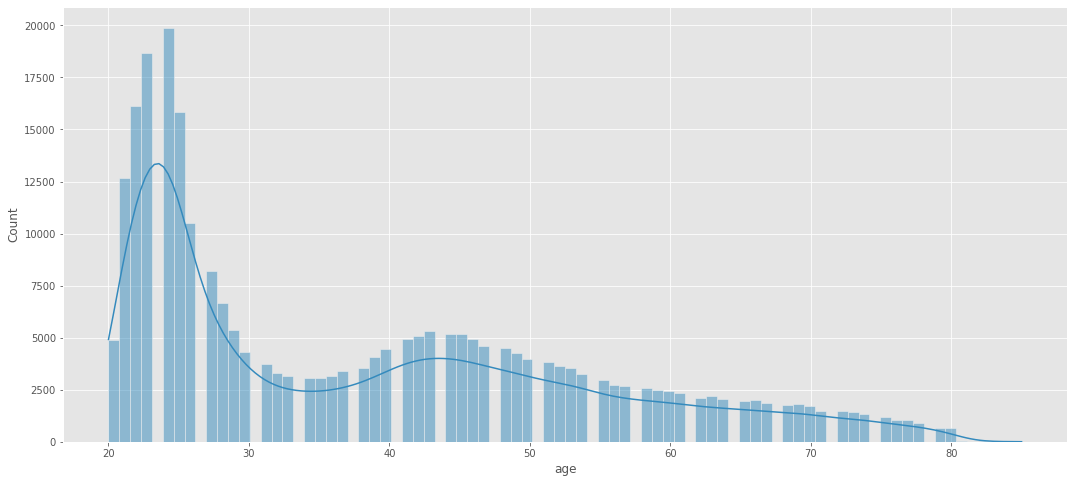

In [226]:
aux = df5.loc[df5['response'] == 0, 'age']
sns.histplot(data=aux, kde=True);

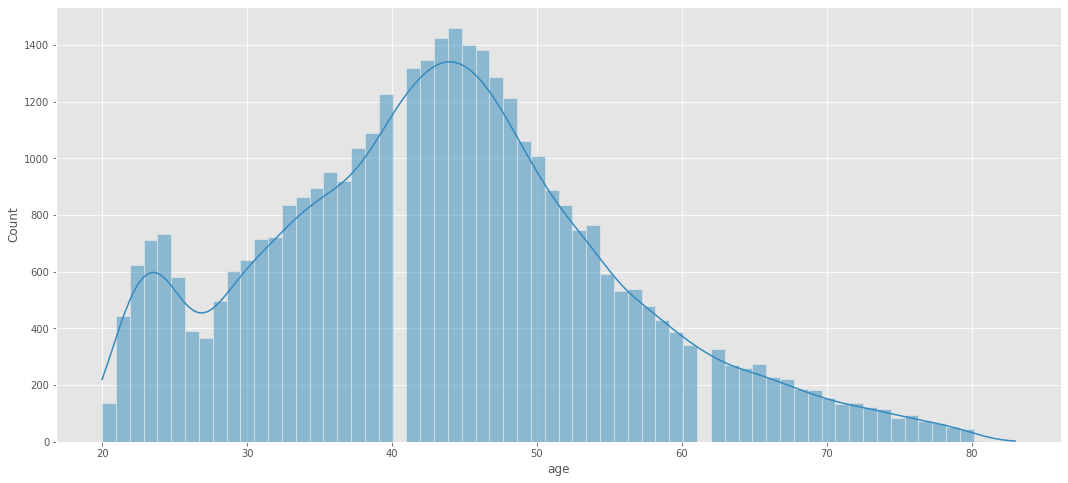

In [227]:
aux = df5.loc[df5['response'] == 1, 'age']
sns.histplot(data=aux, kde=True);

### Driving license

In [228]:
df5[['driving_license', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,driving_license,response,count
0,1,0,266809
1,1,1,37419
2,0,0,624
3,0,1,35


In [229]:
df5[['driving_license', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,driving_license,response,percent
0,1,0,0.875108
1,1,1,0.122731
2,0,0,0.002047
3,0,1,0.000115


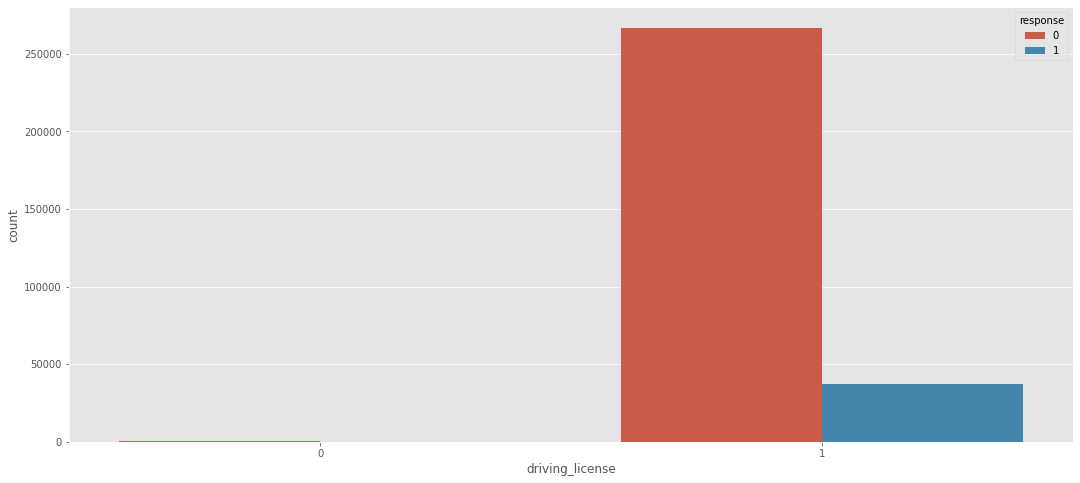

In [230]:
sns.countplot(x='driving_license', hue='response', data=df5);

### Region code

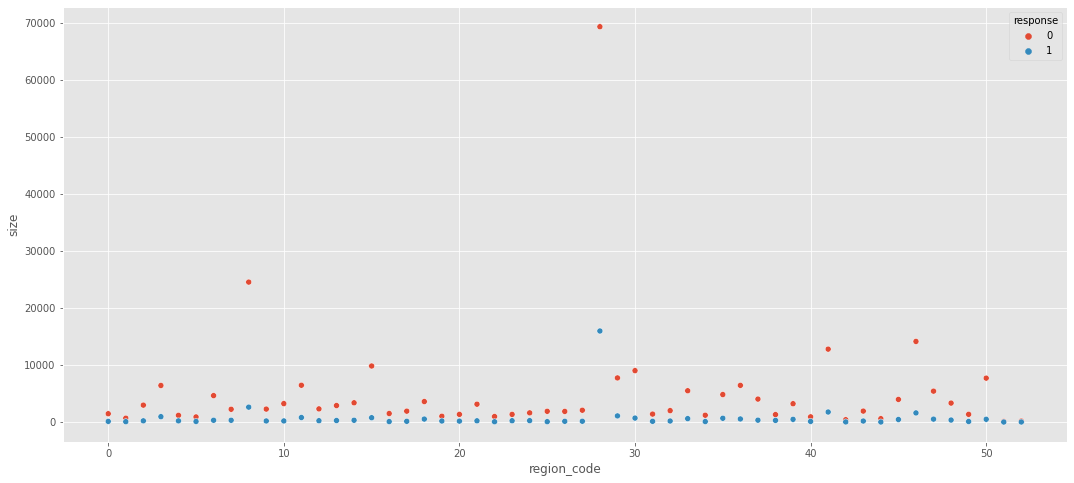

In [231]:
aux = df5.groupby(['region_code', 'response'], as_index=False)['region_code'].size()
sns.scatterplot(x='region_code', y='size', hue='response', data=aux);

### Previously insured

In [232]:
df5[['previously_insured', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,previously_insured,response,count
0,1,0,139504
1,0,0,127929
2,0,1,37334
3,1,1,120


In [233]:
df5[['previously_insured', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,previously_insured,response,percent
0,1,0,0.457560
1,0,0,0.419595
2,0,1,0.122452
3,1,1,0.000394


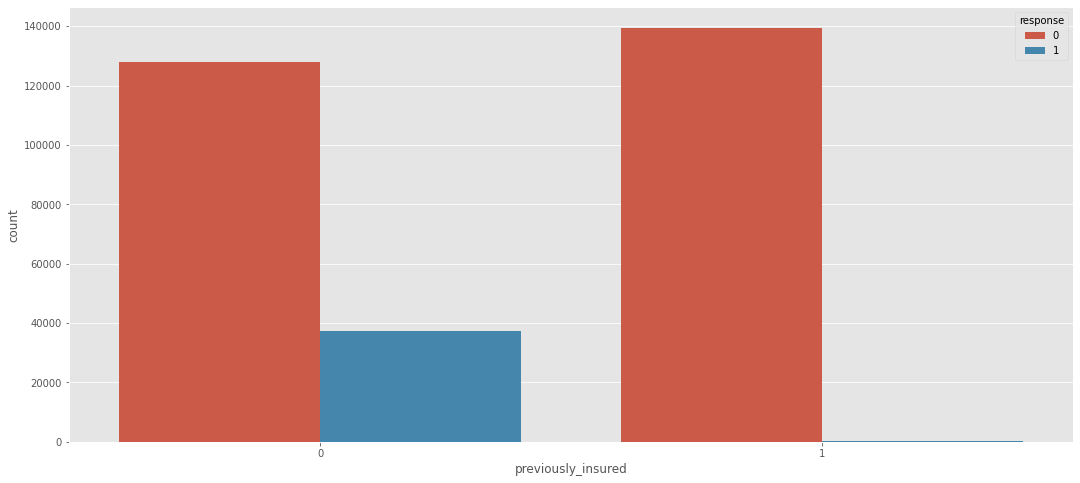

In [234]:
sns.countplot(x='previously_insured', hue='response', data=df5);

### Vehicle age

In [235]:
df5[['vehicle_age', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,vehicle_age,response,count
0,1-2 Year,0,132599
1,< 1 Year,0,125774
2,1-2 Year,1,27915
3,> 2 Years,0,9060
4,< 1 Year,1,5756
5,> 2 Years,1,3783


In [236]:
df5[['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,vehicle_age,response,percent
0,1-2 Year,0,0.434912
1,< 1 Year,0,0.412527
2,1-2 Year,1,0.091559
3,> 2 Years,0,0.029716
4,< 1 Year,1,0.018879
5,> 2 Years,1,0.012408


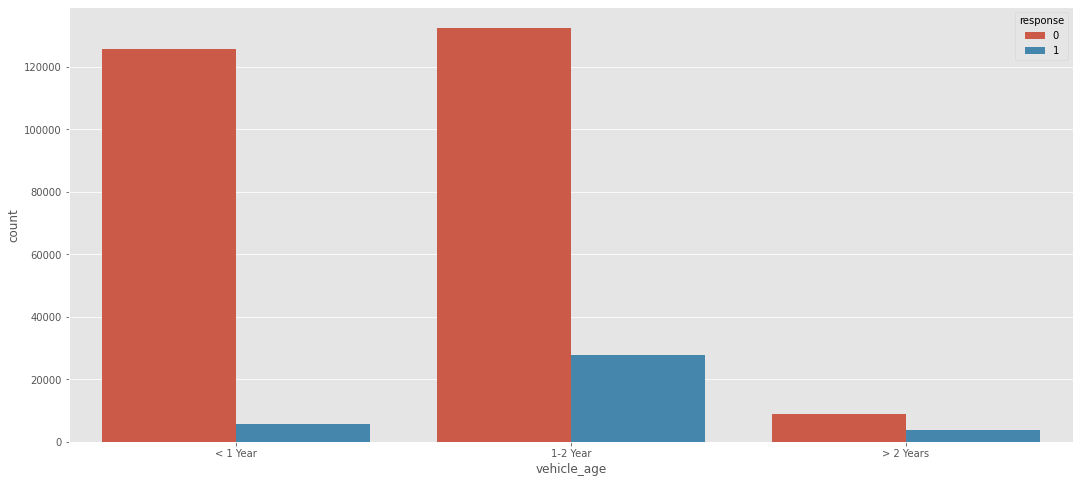

In [237]:
sns.countplot(x='vehicle_age', hue='response', data=df5);

### Vehicle_damage

In [238]:
df5[['vehicle_damage', 'response']].value_counts().reset_index().rename(columns={0:'count'})

,vehicle_damage,response,count
0,No,0,149878
1,Yes,0,117555
2,Yes,1,36672
3,No,1,782


In [239]:
df5[['vehicle_damage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0:'percent'})

,vehicle_damage,response,percent
0,No,0,0.491585
1,Yes,0,0.385569
2,Yes,1,0.120281
3,No,1,0.002565


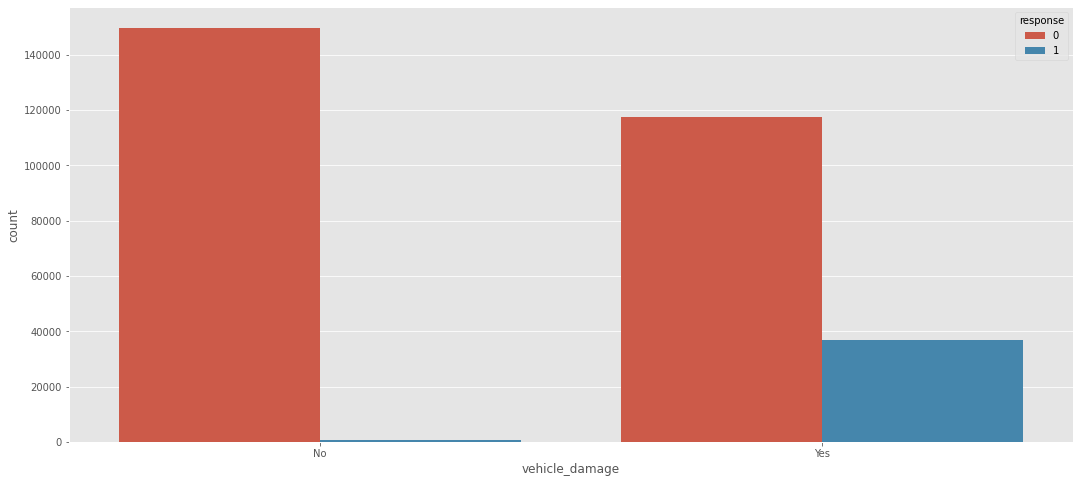

In [240]:
sns.countplot(x='vehicle_damage', hue='response', data=df5);

### Annual premium

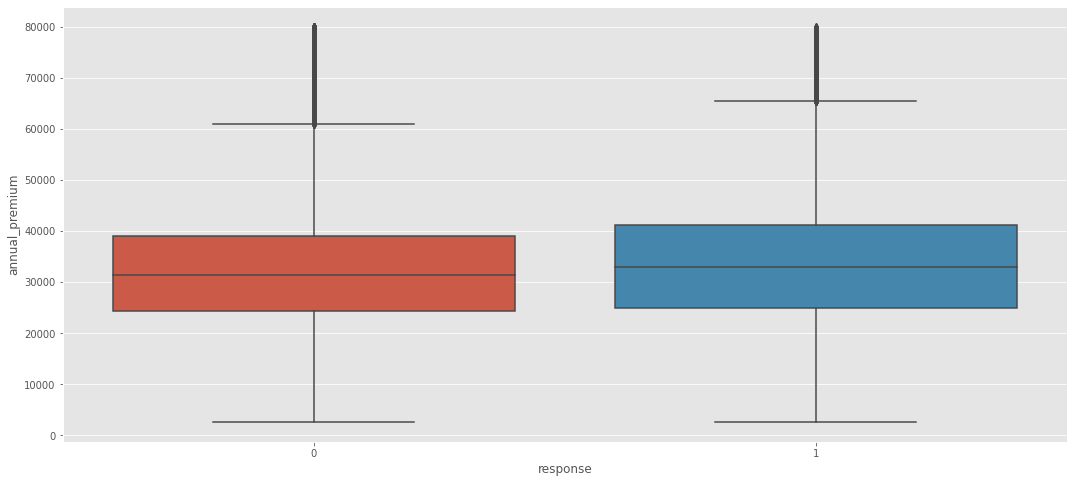

In [241]:
aux = df5[df5['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux);

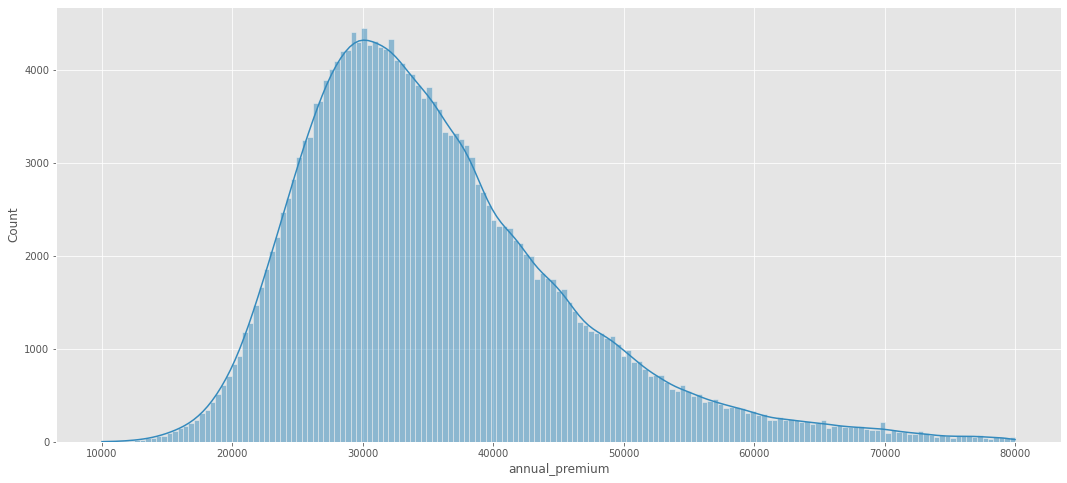

In [242]:
aux = df5[(df5['annual_premium'] > 10000) &(df5['annual_premium'] < 80000)]
aux = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(data=aux, kde=True);

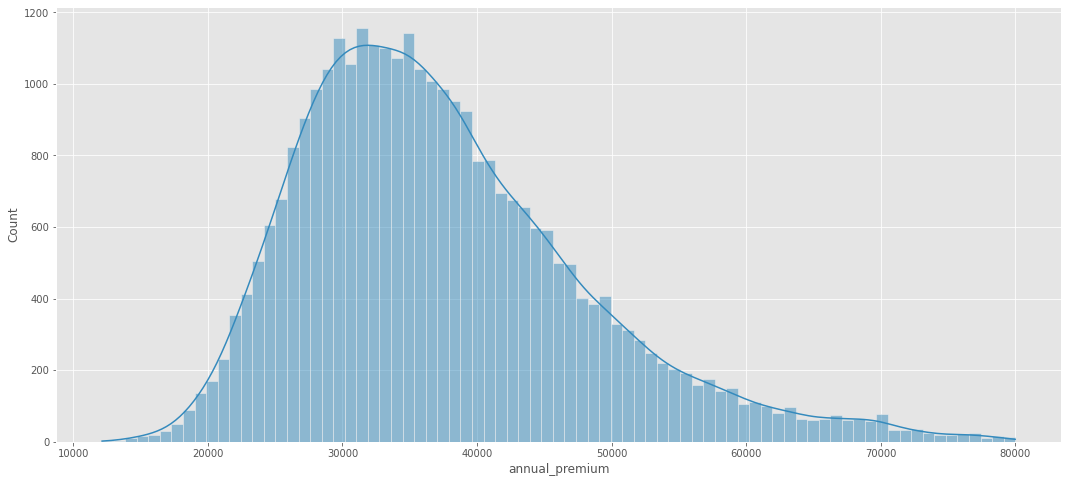

In [243]:
aux = df5[(df5['annual_premium'] > 10000) &(df5['annual_premium'] < 80000)]
aux = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(data=aux, kde=True);

### Policy sales channel

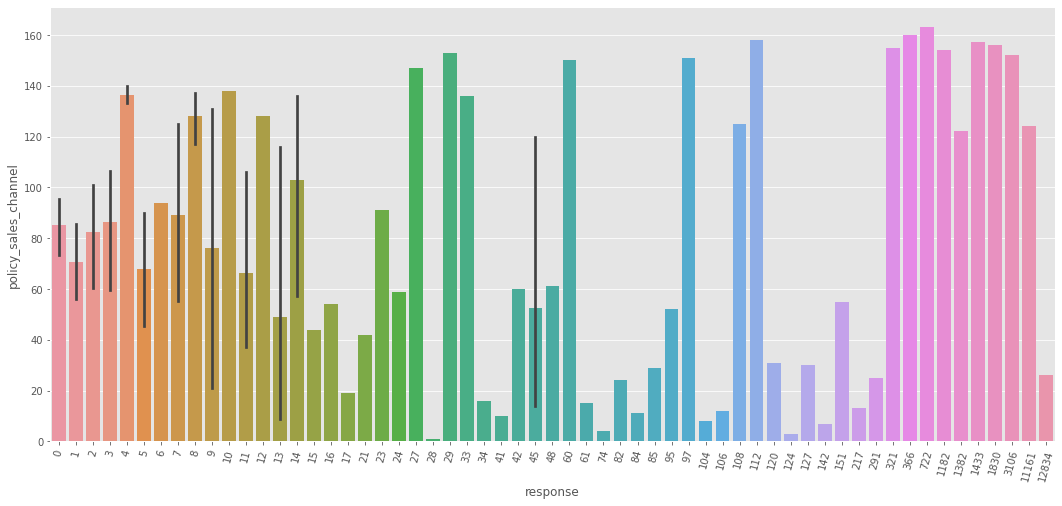

In [244]:
aux = df5[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux)
plt.xticks(rotation=75);

### Vintage

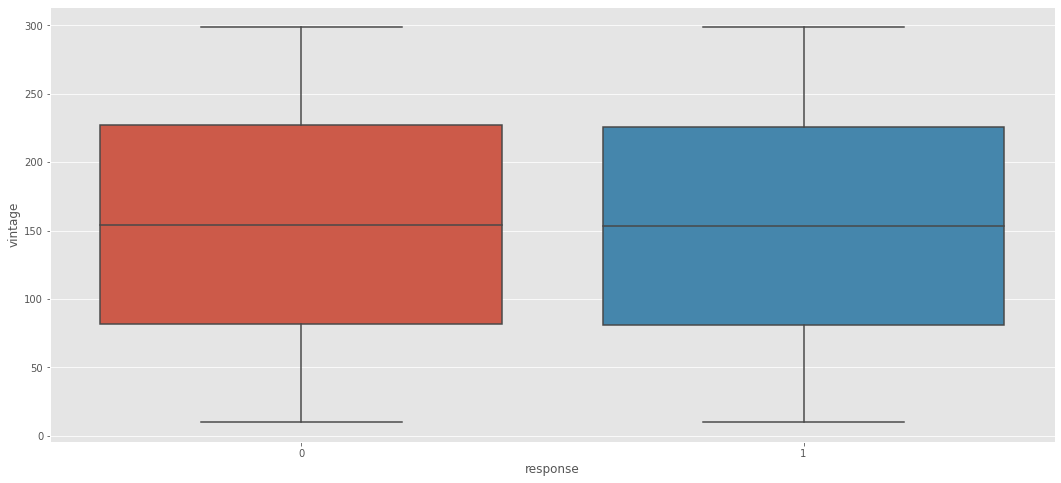

In [245]:
sns.boxplot(x='response', y='vintage', data=df5);

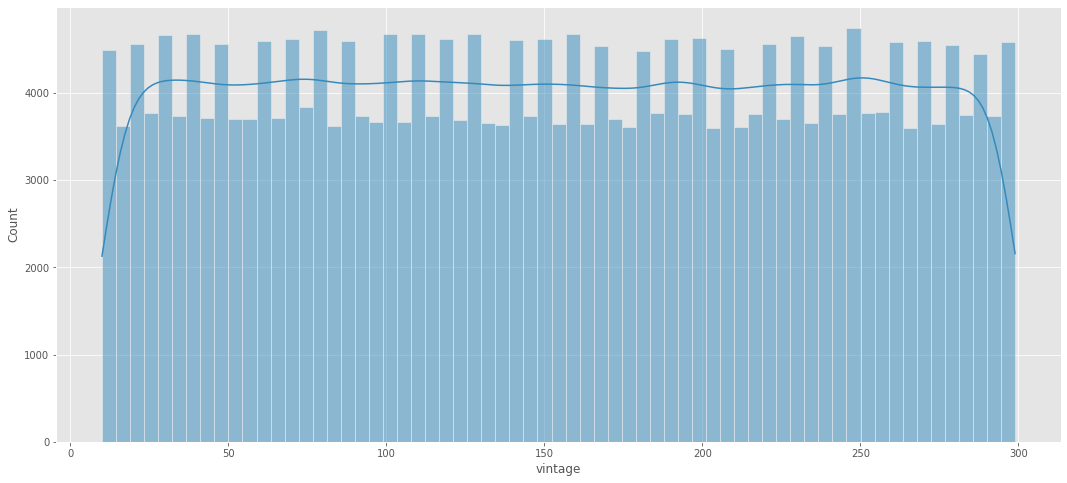

In [246]:
aux = df5.loc[df5['response'] == 0, 'vintage']
sns.histplot(data=aux, kde=True);

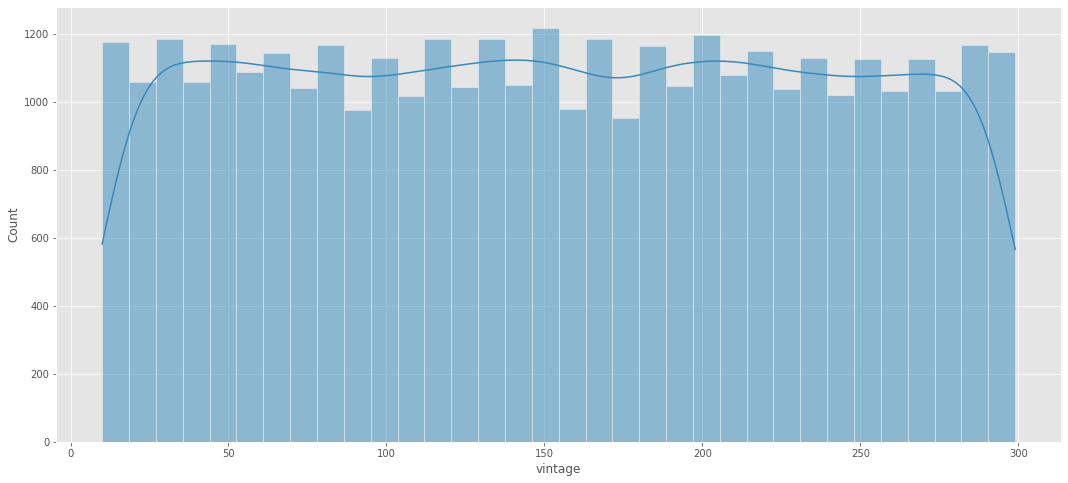

In [247]:
aux = df5.loc[df5['response'] == 1, 'vintage']
sns.histplot(data=aux, kde=True);

## 5.2 - Análise bivariada

### **Hipótese 1 - Homens se acidentam 30% mais que as mulheres.**
Falso, homens se acidentam 17,19% mais.

In [248]:
aux = df5.groupby(['gender', 'vehicle_damage'], as_index=False)['vehicle_damage'].size()
aux = aux[aux['vehicle_damage'] == 'Yes']
aux['percent'] = (aux['size']/aux['size'].sum()) * 100
aux

,gender,vehicle_damage,size,percent
1,Female,Yes,63812,41.375375
3,Male,Yes,90415,58.624625


In [249]:
aux.loc[3, 'percent'] - aux.loc[1, 'percent']

17.24924948290507

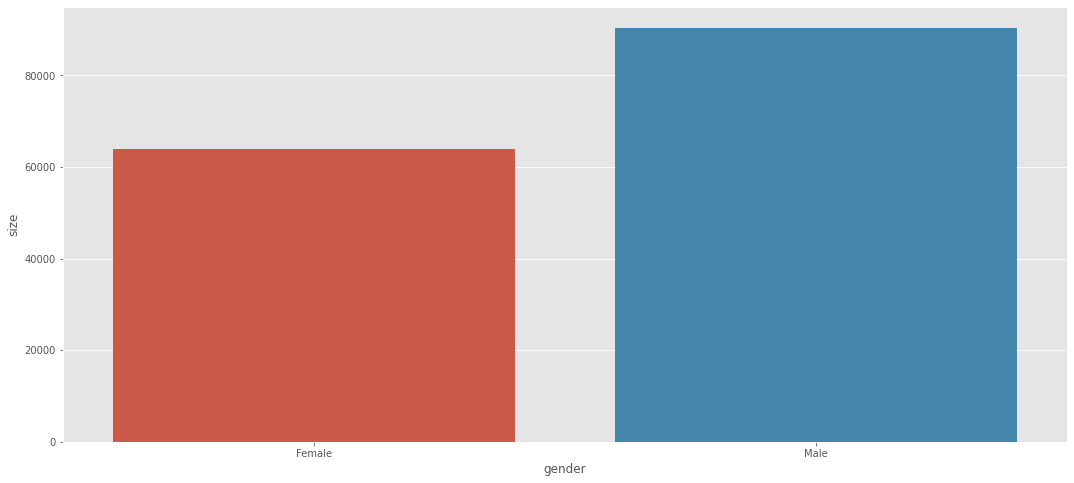

In [250]:
sns.barplot(x='gender', y='size', data=aux);

### **Hipótese 2 - Há 30% mais homens habilitados do que as mulheres.**
Falso, há apenas 8,06% homens a mais que mulheres

In [251]:
aux = df5.groupby(['gender', 'driving_license'], as_index=False)['driving_license'].size()
aux = aux[aux['driving_license'] == 1]
aux['percent'] = (aux['size']/aux['size'].sum()) * 100
aux

,gender,driving_license,size,percent
1,Female,1,139690,45.916221
3,Male,1,164538,54.083779


In [252]:
aux.loc[3, 'percent'] - aux.loc[1, 'percent']

8.167558541620096

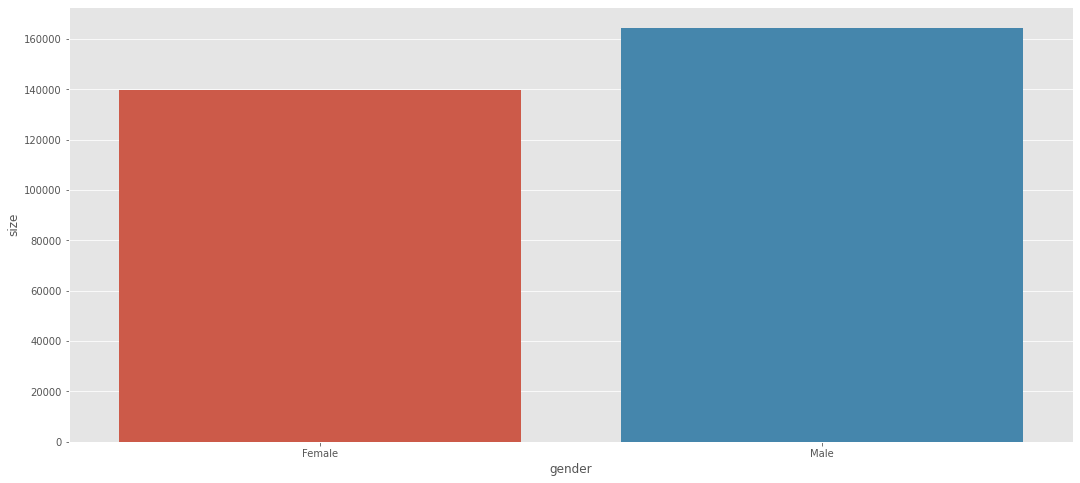

In [253]:
sns.barplot(x='gender', y='size', data=aux);

### **Hipótese 3 - Mais de 50% das mulheres dirigem carros com menos de 1 ano enquanto mais de 50% dos homens dirigem carros com mais antigos.**
Verdadeiro, pois 52,17% das mulheres dirigem veículos abaixo de 1 ano, enquanto apenas 59,35% dos homens dirigem veículos entre 1 e 2 anos e 5% mais de 2 anos.

In [254]:
aux_f = df5.groupby(['gender', 'vehicle_age'], as_index=False)['previously_insured'].size()
aux_f = aux_f[aux_f['gender'] == 'Female']
aux_f['percent'] = (aux_f['size']/aux_f['size'].sum()) * 100
aux_f

,gender,vehicle_age,size,percent
0,Female,1-2 Year,62443,44.646790
1,Female,< 1 Year,72845,52.084227
2,Female,> 2 Years,4572,3.268983


In [255]:
aux_m = df5.groupby(['gender', 'vehicle_age'], as_index=False)['previously_insured'].size()
aux_m = aux_m[aux_m['gender'] == 'Male']
aux_m['percent'] = (aux_m['size']/aux_m['size'].sum()) * 100
aux_m

,gender,vehicle_age,size,percent
3,Male,1-2 Year,98071,59.427245
4,Male,< 1 Year,58685,35.560848
5,Male,> 2 Years,8271,5.011907


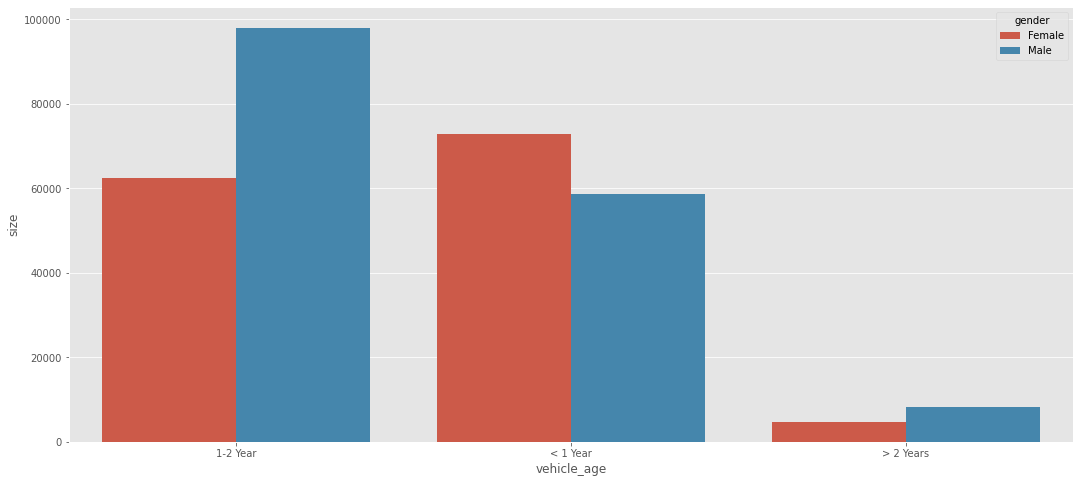

In [256]:
aux = pd.concat([aux_f, aux_m])
sns.barplot(x='vehicle_age', y='size', hue='gender', data=aux);

### Hipótese 4 - Mais de 40% de homens e mulheres possuem seguro veicular.
Verdadeiro, pois 50,25% das mulheres possuem seguro veicular, enquanto apenas 42% do homens possuem.

In [257]:
aux_f = df5.groupby(['gender', 'previously_insured'], as_index=False)['previously_insured'].size()
aux_f = aux_f[aux_f['gender'] == 'Female']
aux_f['percent'] = (aux_f['size']/aux_f['size'].sum()) * 100
aux_f

,gender,previously_insured,size,percent
0,Female,0,69618,49.77692
1,Female,1,70242,50.22308


In [258]:
aux_m = df5.groupby(['gender', 'previously_insured'], as_index=False)['previously_insured'].size()
aux_m = aux_m[aux_m['gender'] == 'Male']
aux_m['percent'] = (aux_m['size']/aux_m['size'].sum()) * 100
aux_m

,gender,previously_insured,size,percent
2,Male,0,95645,57.957183
3,Male,1,69382,42.042817


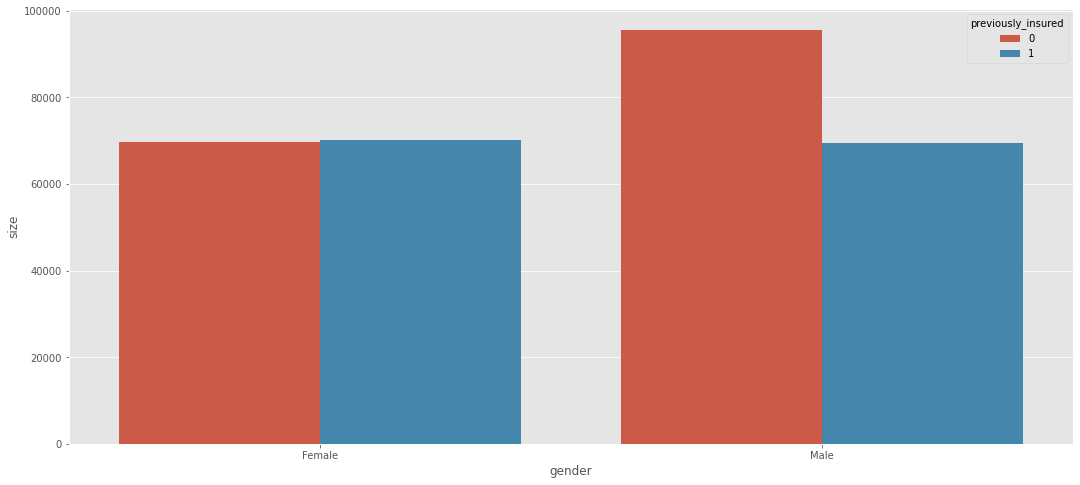

In [259]:
aux = pd.concat([aux_f, aux_m])
sns.barplot(x='gender', y='size', hue='previously_insured', data=aux);

### **Hipótese 5 - Pessoas com menos de 40 anos se acidentam 20% mais.**
Falso, pessoas com menos de 40 anos se acidentam 18,74% menos

In [260]:
aux = df5.copy()
aux['age_40'] = aux['age'].apply(lambda x: 'menor_40' if x < 40 else 'maior_40')

In [261]:
aux1 = aux.groupby(['age_40', 'vehicle_damage'], as_index=False)['vehicle_damage'].size()
aux1 = aux1[aux1['vehicle_damage'] == 'Yes']
aux1['percent'] = (aux1['size']/aux1['size'].sum()) * 100
aux1

,age_40,vehicle_damage,size,percent
1,maior_40,Yes,91635,59.415667
3,menor_40,Yes,62592,40.584333


In [262]:
aux1.loc[1, 'percent'] - aux1.loc[3, 'percent']

18.83133303507168

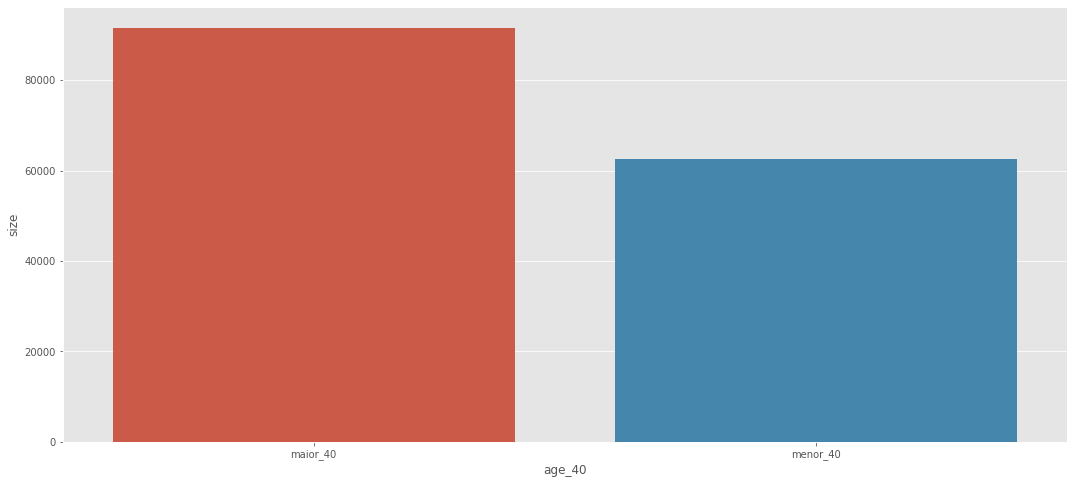

In [263]:
sns.barplot(x='age_40', y='size', data=aux1);

### **Hipótese 6 - Mais de 50% pessoas com menos de 40 anos dirigem carros mais novos (com menos de 1 ano), enquanto mais de 40% da pessoas com mais de 40 dirigem carros mais antigos.**
Verdadeiro, pois 78,36% das pessoas com menos de 40 anos dirigem veículos com menos de 1 ano, enquanto pessoas com mais de 40 anos dirigem 90% veículos entre 1 e 2 anos e 8,74 veículos com mais de 2 anos.

In [264]:
aux = df5.copy()
aux['age_40'] = aux['age'].apply(lambda x: 'menor_40' if x < 40 else 'maior_40')

In [265]:
aux1 = aux.groupby(['age_40', 'vehicle_age'], as_index=False)['vehicle_age'].size()
aux1 = aux1[aux1['age_40'] == 'menor_40']
aux1['percent'] = (aux1['size']/aux1['size'].sum()) * 100
aux1

,age_40,vehicle_age,size,percent
3,menor_40,1-2 Year,35569,21.249052
4,menor_40,< 1 Year,131005,78.262870
5,menor_40,> 2 Years,817,0.488079


In [266]:
aux2 = aux.groupby(['age_40', 'vehicle_age'], as_index=False)['vehicle_age'].size()
aux2 = aux2[aux2['age_40'] == 'maior_40']
aux2['percent'] = (aux2['size']/aux2['size'].sum()) * 100
aux2

,age_40,vehicle_age,size,percent
0,maior_40,1-2 Year,124945,90.871734
1,maior_40,< 1 Year,525,0.381829
2,maior_40,> 2 Years,12026,8.746436


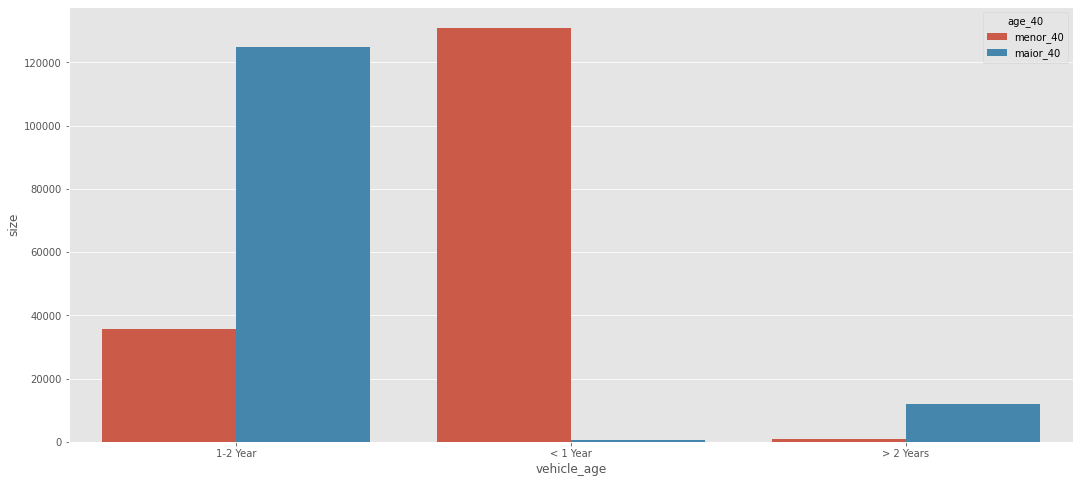

In [267]:
aux = pd.concat([aux1, aux2])
sns.barplot(x='vehicle_age', y='size', hue='age_40', data=aux);

### **Hipótese 7 - Menos de 40% das pessoas com menos de 40 anos dirigem sem seguro no veículo, enquanto mais de 70% das pessoas com mais de 40 anos possuem seguro.**
Falso, pois 41,53% das pessoas com menos de 40 anos não possuem seguro, 69,6% das pessoas com mais de 40 anos não possuem.

In [268]:
aux = df5.copy()
aux['age_40'] = aux['age'].apply(lambda x: 'menor_40' if x < 40 else 'maior_40')

In [269]:
aux1 = aux.groupby(['age_40', 'previously_insured'], as_index=False)['previously_insured'].size()
aux1 = aux1[aux1['age_40'] == 'menor_40']
aux1['percent'] = (aux1['size']/aux1['size'].sum()) * 100
aux1

,age_40,previously_insured,size,percent
2,menor_40,0,69538,41.542257
3,menor_40,1,97853,58.457743


In [270]:
aux2 = aux.groupby(['age_40', 'previously_insured'], as_index=False)['previously_insured'].size()
aux2 = aux2[aux2['age_40'] == 'maior_40']
aux2['percent'] = (aux2['size']/aux2['size'].sum()) * 100
aux2

,age_40,previously_insured,size,percent
0,maior_40,0,95725,69.620207
1,maior_40,1,41771,30.379793


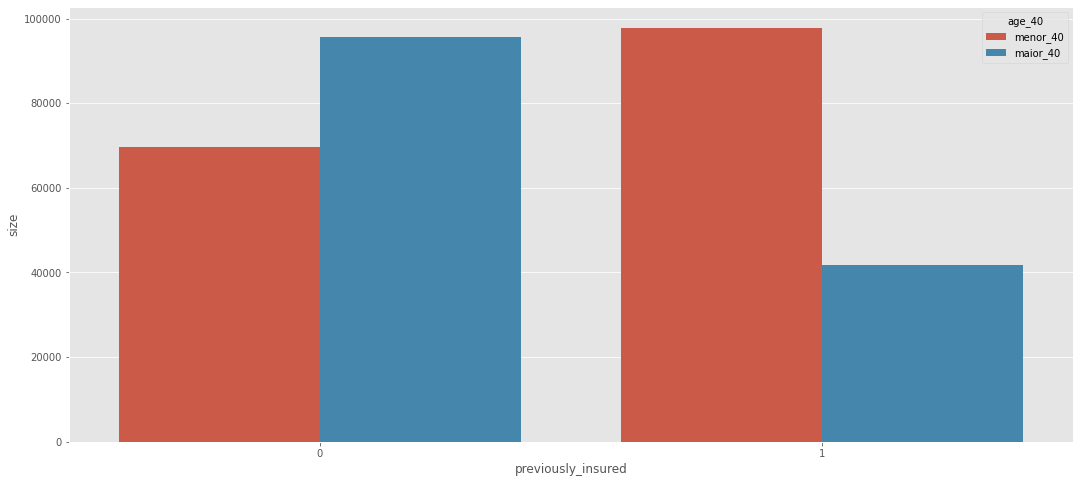

In [271]:
aux = pd.concat([aux1, aux2])
sns.barplot(x='previously_insured', y='size', hue='age_40', data=aux);

## 5.2.1 - Resumo das hipóteses

In [272]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Baixa'],
['H3', 'Verdadeira', 'Média'],
['H4', 'Verdadeira', 'Alta'],
['H5', 'Falsa', 'Alta'],
['H6', 'Verdadeira', 'Média'],
['H7', 'Falsa', 'Alta']
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Verdadeira   Média
H4           Verdadeira   Alta
H5           Falsa        Alta
H6           Verdadeira   Média
H7           Falsa        Alta


## 5.3 - Análise multivariada

### 5.3.1 - Análise numérica

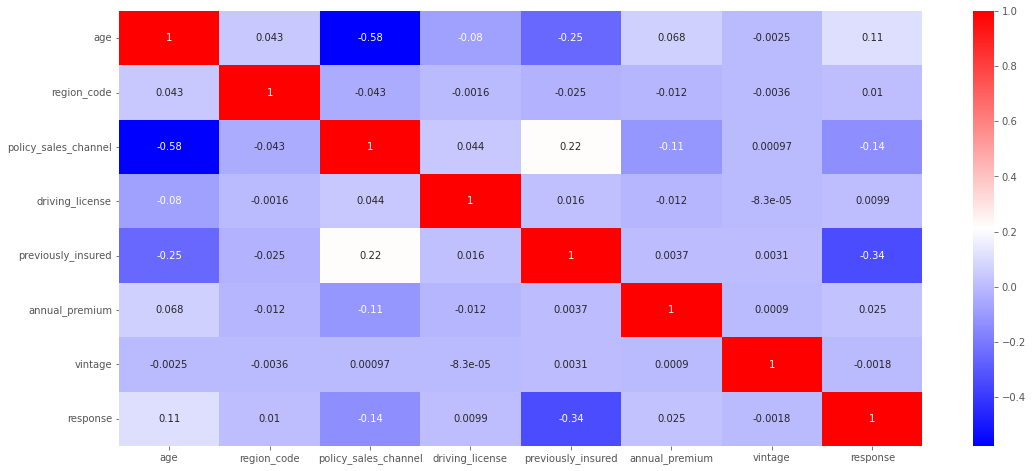

In [273]:
# Método de pearson
correlacao = num.drop('id', axis=1).corr()
sns.heatmap(correlacao, annot=True, cmap='bwr');

### 5.3.2 - Análise categórica

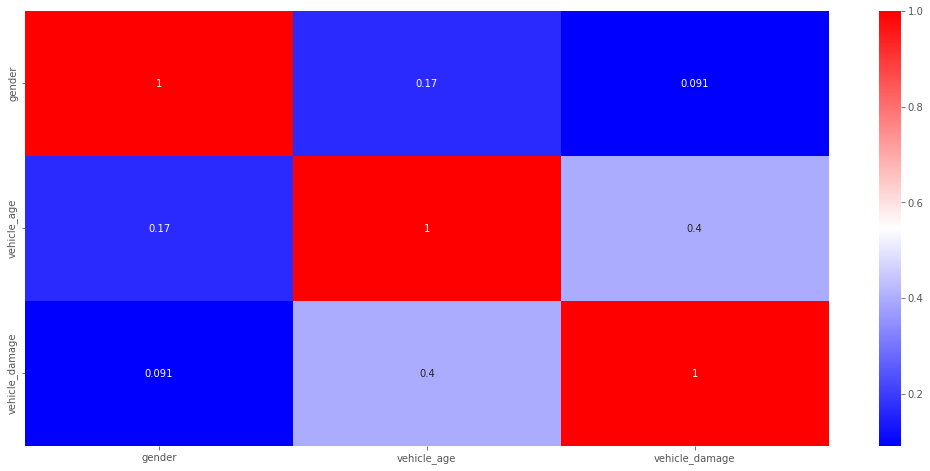

In [274]:
# Método de Cramer
correlacao = corr_matrix(cat, cat.columns)
sns.heatmap(correlacao, annot=True, cmap='bwr');

# 6 - Preparação dos dados

In [275]:
df6 = df5.copy()

## 6.1 - Separação do dataframe entre treino e teste

In [276]:
# Separando os dados de entrada e o alvo
X = df6.drop(['id', 'response'], axis=1)
y = df6['response']

# Separando os dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Tamanho do X_train: {X_train.shape} e y_train:{y_train.shape}')
print(f'Tamanho do X_test: {X_test.shape} e y_test:{y_test.shape}')

Tamanho do X_train: (243909, 10) e y_train:(243909,)
Tamanho do X_test: (60978, 10) e y_test:(60978,)


## 6.2 - Normalização

In [277]:
ss_annual_premium = StandardScaler()

# -------------------- Treino --------------------
X_train['annual_premium'] = ss_annual_premium.fit_transform(X_train[['annual_premium']])
joblib.dump(ss_annual_premium, '../src/features/ss_annual_premium.joblib')

# -------------------- Teste --------------------
X_test['annual_premium'] = ss_annual_premium.transform(X_test[['annual_premium']])

## 6.3 - Rescaling

In [278]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# -------------------- Treino --------------------
X_train['age'] = mms_age.fit_transform(X_train[['age']])
joblib.dump(mms_age, '../src/features/mms_age.joblib')

X_train['vintage'] = mms_vintage.fit_transform(X_train[['vintage']])
joblib.dump(mms_vintage, '../src/features/mms_vintage.joblib')

# -------------------- Teste --------------------
X_test['vintage'] = mms_age.transform(X_test[['vintage']])
X_test['vintage'] = mms_vintage.transform(X_test[['vintage']])

## 6.4 - Transformação

### 6.4.1 - Encoding

In [279]:
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df6 ) 

# -------------------- Treino --------------------
X_train['vehicle_damage'] = X_train['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)
X_train = pd.get_dummies( X_train, prefix='vehicle_age', columns=['vehicle_age'] )

X_train.loc[:, 'gender'] = X_train['gender'].map( target_encode_gender )
joblib.dump(target_encode_gender, '../src/features/target_encode_gender.joblib')

X_train.loc[:, 'region_code'] = X_train['region_code'].map( target_encode_region_code )
joblib.dump(target_encode_region_code, '../src/features/target_encode_region_code.joblib')

X_train.loc[:, 'policy_sales_channel'] = X_train['policy_sales_channel'].map( fe_policy_sales_channel )
joblib.dump(fe_policy_sales_channel, '../src/features/fe_policy_sales_channel.joblib')

# -------------------- Teste --------------------
X_test['vehicle_damage'] = X_test['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)
X_test = pd.get_dummies( X_test, prefix='vehicle_age', columns=['vehicle_age'] )
X_test.loc[:, 'gender'] = X_test['gender'].map( target_encode_gender )
X_test.loc[:, 'region_code'] = X_test['region_code'].map( target_encode_region_code )
X_test.loc[:, 'policy_sales_channel'] = X_test['policy_sales_channel'].map( fe_policy_sales_channel )

### 6.4.2 - Transformação da variável resposta

### 6.4.3 - Transformação de natureza

# 7 - Seleção de features

## 7.1 - Excluir colunas para a seleção

## 7.2 - Seleção de features

In [82]:
# model definition
forest = ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
forest.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                 feature  importance
0                vintage    0.270262
0         annual_premium    0.241468
0                    age    0.168420
0            region_code    0.106502
0         vehicle_damage    0.067591
0   policy_sales_channel    0.060688
0     previously_insured    0.057200
0   vehicle_age_< 1 Year    0.012902
0   vehicle_age_1-2 Year    0.006953
0                 gender    0.004989
0  vehicle_age_> 2 Years    0.002491
0        driving_license    0.000536


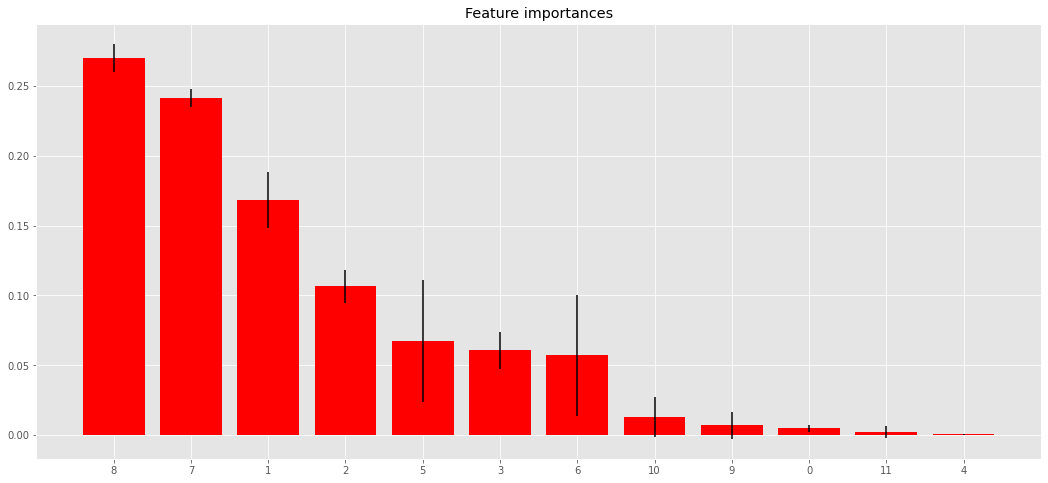

In [83]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( X_train, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## 7.3 - Seleção manual das features

In [280]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

In [281]:
X_train_fs = X_train[cols_selected]
X_test_fs = X_test[cols_selected]

y_train_fs = y_train.copy()
y_test_fs = y_test.copy()

# Salvando os dados de treino e teste
X_train_fs.to_csv('../data/X_train_fs.csv')
X_test_fs.to_csv('../data/X_test_fs.csv')

y_train_fs.to_csv('../data/y_train_fs.csv')
y_test_fs.to_csv('../data/y_test_fs.csv')

# 8 - Modelos de Machine Learning

In [282]:
# Lista para teste de precision e racall
lista = [0.3, 0.5, 0.7]

## 8.1 - Modelo Logistic Regression

In [283]:
# Modelo
lr_model = LogisticRegression()

# Treinando o modelo
lr_model.fit(X_train_fs, y_train_fs)

# Predição do modelo
y_pred_lr = lr_model.predict_proba(X_test_fs)

# Dataframe da performance
df_lr = performance('Logistic Regression', y_test_fs, y_pred_lr)

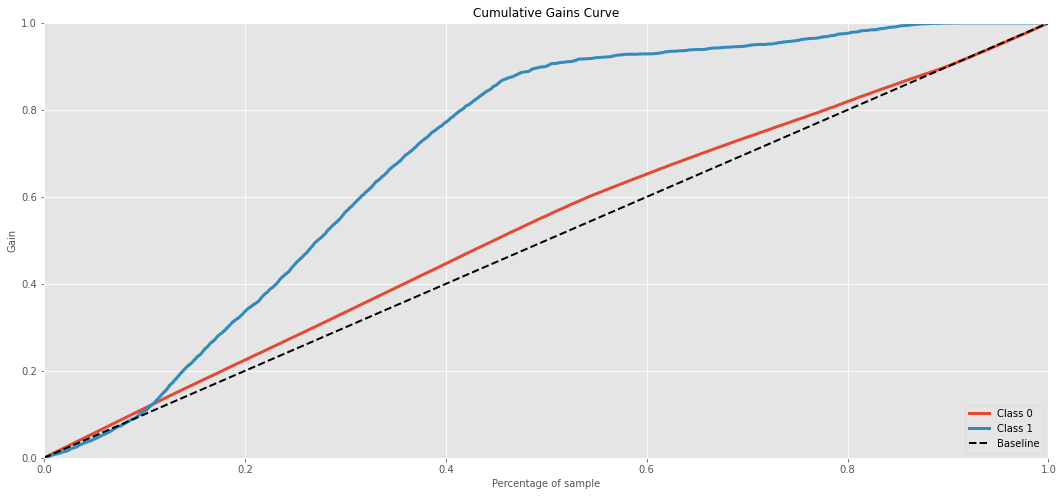

In [284]:
# Curva de ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_test_fs, y_pred_lr);

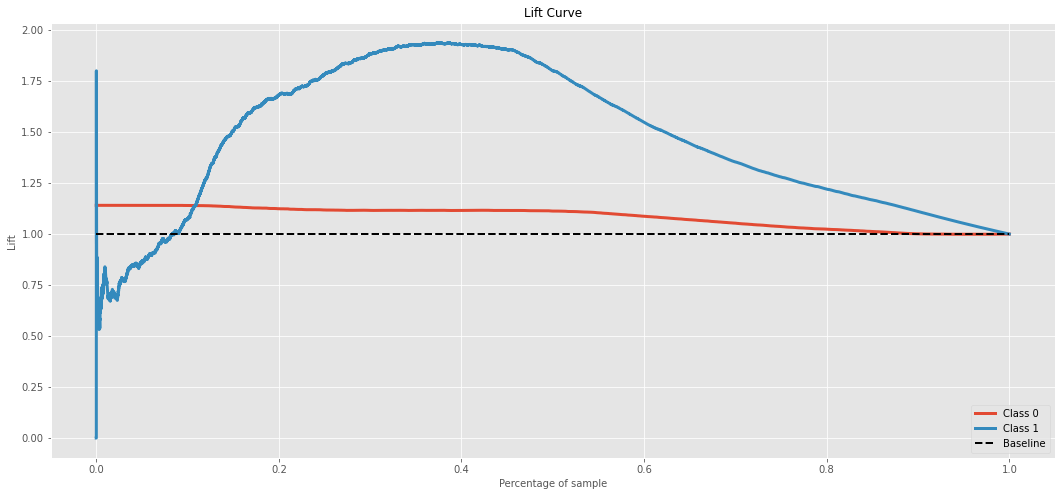

In [285]:
#Curva LIFT
skplt.metrics.plot_lift_curve(y_test_fs, y_pred_lr);

In [286]:
df8 = X_test.copy()
df8['response'] = y_test.copy()

for e in lista:
    precision_k = precision(df8, y_pred_lr, e)
    print(f'A precisão em top {e*100}% é: {round(precision_k, 2)}')

    recall_k = recall(df8, y_pred_lr, e)
    print(f'O recall em top {e*100}% é: {round(recall_k, 2)}\n')

A precisão em top 30.0% é: 0.23
O recall em top 30.0% é: 0.57

A precisão em top 50.0% é: 0.22
O recall em top 50.0% é: 0.9

A precisão em top 70.0% é: 0.17
O recall em top 70.0% é: 0.95



### 8.1.1 - Logistic Regression com cross validation

In [287]:
df_lr_cv = cross_validation('Logistic Regression', lr_model, 3, X_train_fs, y_train_fs, 0.3)
df_lr_cv

,model_name,Precision,Recall
0,Logistic Regression,mean: 0.28 | std: +/- 0.0,mean: 0.68 | std: +/- 0.01


## 8.2 - KNN

In [288]:
# Modelo
knn_model = KNeighborsClassifier()

# Treinando o modelo
knn_model.fit(X_train_fs, y_train_fs)

# Predição do modelo
y_pred_knn = knn_model.predict_proba(X_test_fs)

# Dataframe da performance
df_knn = performance('KNN', y_test_fs, y_pred_knn)

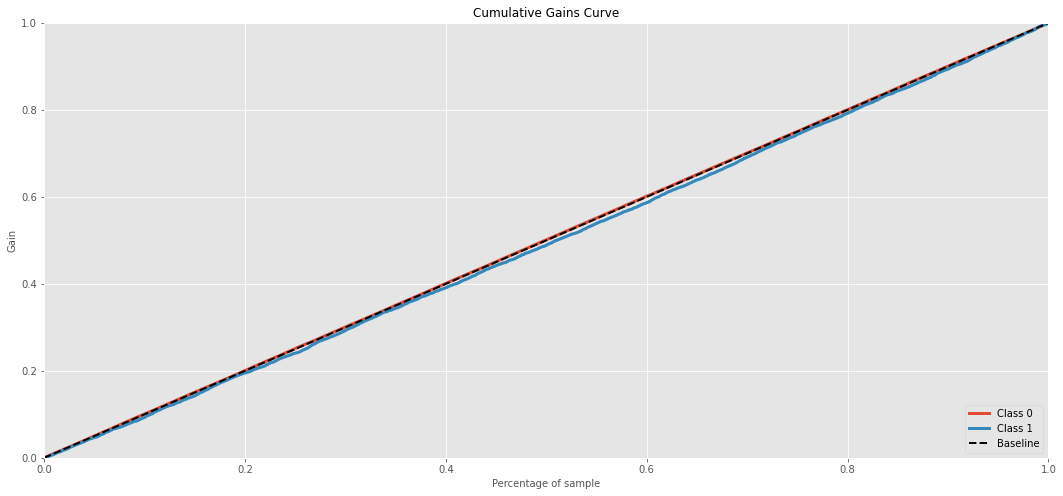

In [289]:
# Curva de ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_test_fs, y_pred_knn);

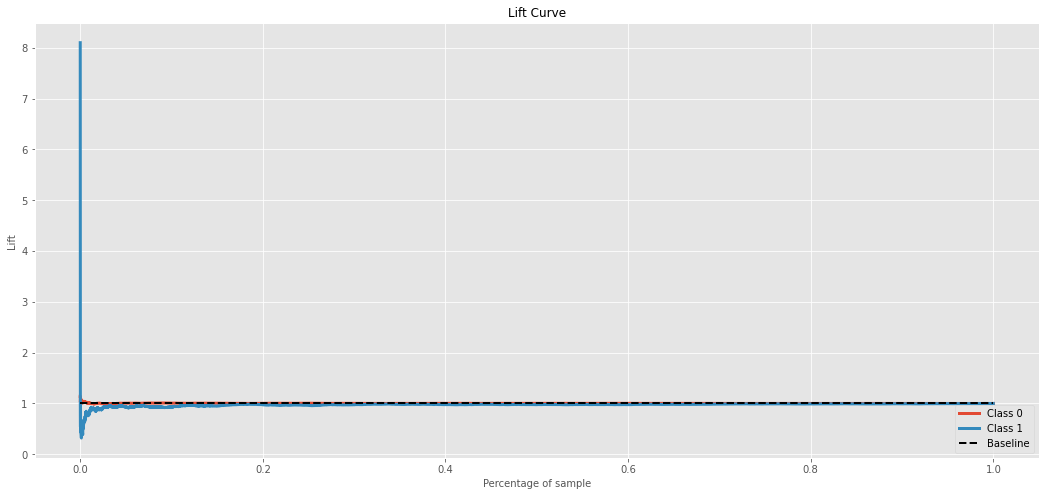

In [290]:
#Curva LIFT
skplt.metrics.plot_lift_curve(y_test_fs, y_pred_knn);

In [291]:
df8 = X_test.copy()
df8['response'] = y_test.copy()

for e in lista:
    precision_k = precision(df8, y_pred_knn, e)
    print(f'A precisão em top {e*100}% é: {round(precision_k, 2)}')

    recall_k = recall(df8, y_pred_knn, e)
    print(f'O recall em top {e*100}% é: {round(recall_k, 2)}\n')

A precisão em top 30.0% é: 0.13
O recall em top 30.0% é: 0.31

A precisão em top 50.0% é: 0.13
O recall em top 50.0% é: 0.51

A precisão em top 70.0% é: 0.12
O recall em top 70.0% é: 0.7



### 8.2.1 - KNN com cross validation

In [292]:
df_knn_cv = cross_validation('KNN', knn_model, 3, X_train_fs, y_train_fs, 0.3)
df_knn_cv

,model_name,Precision,Recall
0,KNN,mean: 0.27 | std: +/- 0.0,mean: 0.67 | std: +/- 0.0


## 8.3 - Random Forest

In [293]:
# Modelo
rf_model = RandomForestClassifier()

# Treinando o modelo
rf_model.fit(X_train_fs, y_train_fs)

# Predição do modelo
y_pred_rf = rf_model.predict_proba(X_test_fs)

# Dataframe da performance
df_rf = performance('Random Forest', y_test_fs, y_pred_rf)

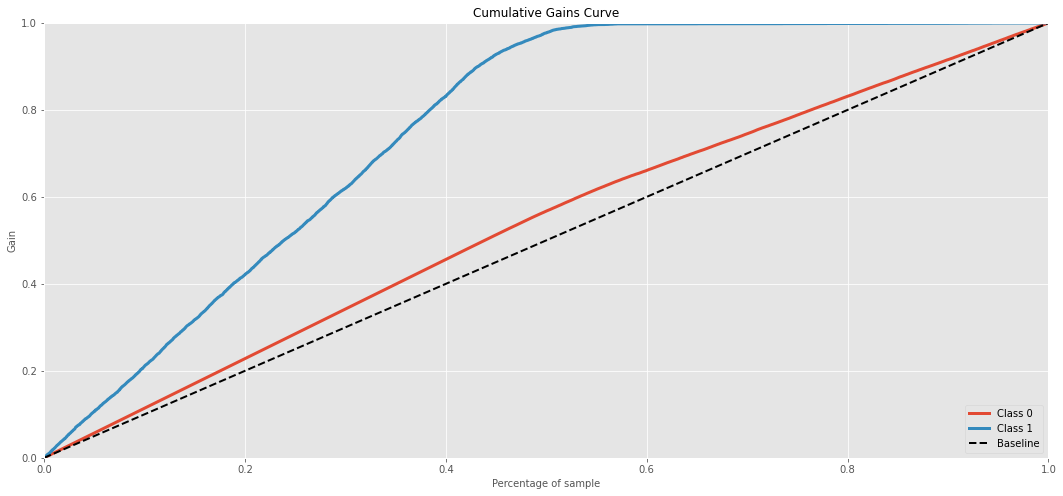

In [294]:
# Curva de ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_test_fs, y_pred_rf);

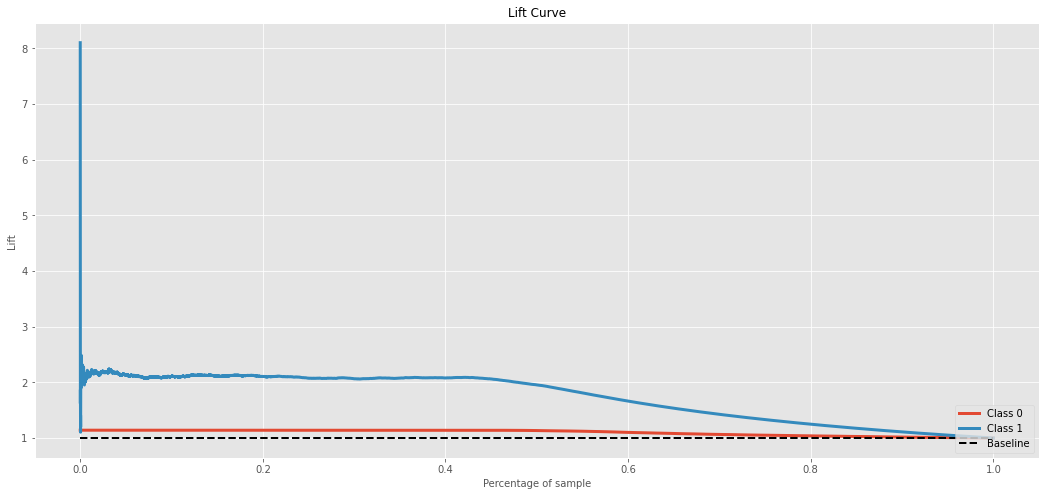

In [295]:
#Curva LIFT
skplt.metrics.plot_lift_curve(y_test_fs, y_pred_rf);

In [296]:
df8 = X_test.copy()
df8['response'] = y_test.copy()

for e in lista:
    precision_k = precision(df8, y_pred_rf, e)
    print(f'A precisão em top {e*100}% é: {round(precision_k, 2)}')

    recall_k = recall(df8, y_pred_rf, e)
    print(f'O recall em top {e*100}% é: {round(recall_k, 2)}\n')

A precisão em top 30.0% é: 0.26
O recall em top 30.0% é: 0.62

A precisão em top 50.0% é: 0.24
O recall em top 50.0% é: 0.98

A precisão em top 70.0% é: 0.18
O recall em top 70.0% é: 1.0



### 8.3.1 Random Forest com cross validation

In [297]:
df_rf_cv = cross_validation('Random Forest', rf_model, 3, X_train_fs, y_train_fs, 0.3)
df_rf_cv

,model_name,Precision,Recall
0,Random Forest,mean: 0.3 | std: +/- 0.0,mean: 0.73 | std: +/- 0.0


## 8.4 - Extra Tree

In [298]:
# Modelo
et_model = RandomForestClassifier()

# Treinando o modelo
et_model.fit(X_train_fs, y_train_fs)

# Predição do modelo
y_pred_et = et_model.predict_proba(X_test_fs)

# Dataframe da performance
df_et = performance('Extra Tree', y_test_fs, y_pred_et)

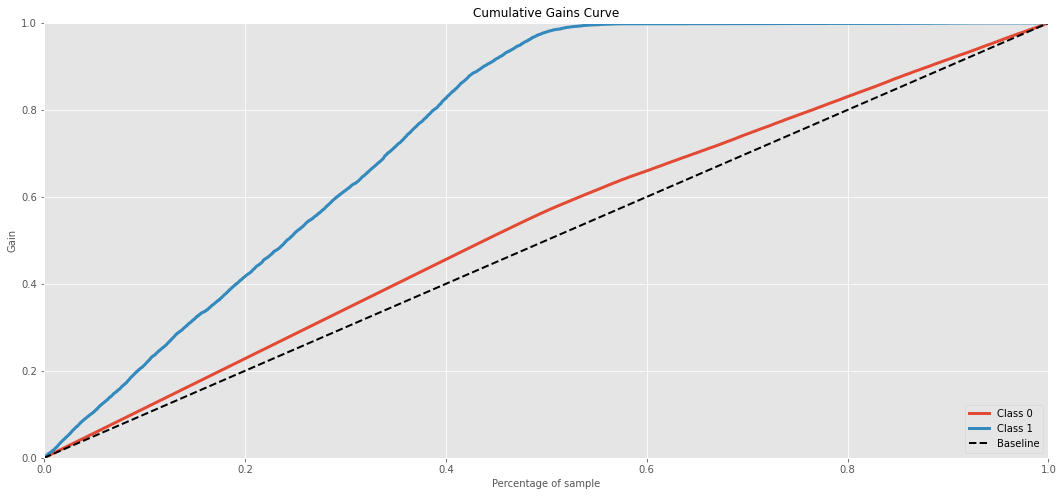

In [299]:
# Curva de ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_test_fs, y_pred_et);

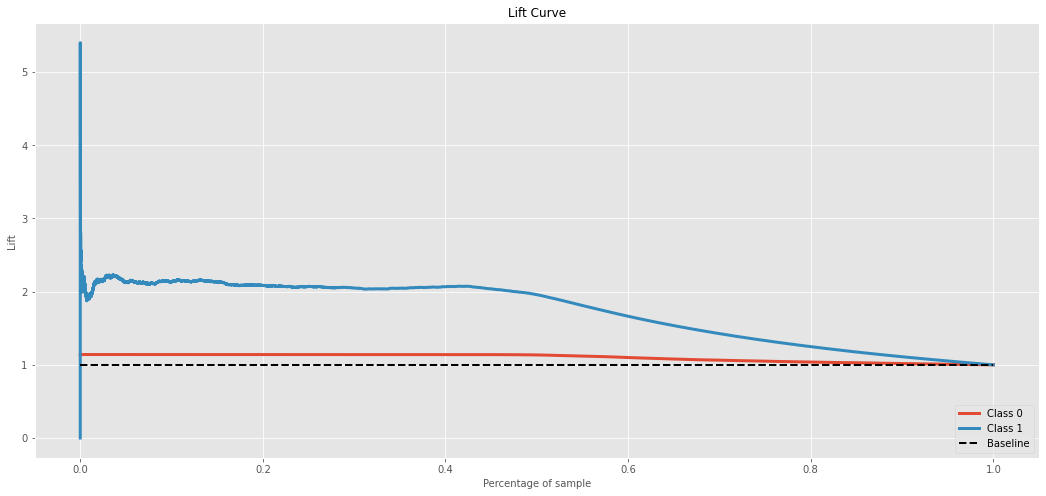

In [300]:
#Curva LIFT
skplt.metrics.plot_lift_curve(y_test_fs, y_pred_et);

In [301]:
df8 = X_test.copy()
df8['response'] = y_test.copy()

for e in lista:
    precision_k = precision(df8, y_pred_et, e)
    print(f'A precisão em top {e*100}% é: {round(precision_k, 2)}')

    recall_k = recall(df8, y_pred_et, e)
    print(f'O recall em top {e*100}% é: {round(recall_k, 2)}\n')

A precisão em top 30.0% é: 0.25
O recall em top 30.0% é: 0.62

A precisão em top 50.0% é: 0.24
O recall em top 50.0% é: 0.98

A precisão em top 70.0% é: 0.18
O recall em top 70.0% é: 1.0



### 8.4.1 - Extra Tree com cross validation

In [302]:
df_et_cv = cross_validation('Extra Tree', et_model, 3, X_train_fs, y_train_fs, 0.3)
df_et_cv

,model_name,Precision,Recall
0,Extra Tree,mean: 0.3 | std: +/- 0.0,mean: 0.73 | std: +/- 0.0


## 8.5 - XGBoost

In [303]:
# Modelo
xgb_model = XGBClassifier()

# Treinando o modelo
xgb_model.fit(X_train_fs, y_train_fs)

# Predição do modelo
y_pred_xgb = xgb_model.predict_proba(X_test_fs)

# Dataframe da performance
df_xgb = performance('XGBoost', y_test_fs, y_pred_xgb)

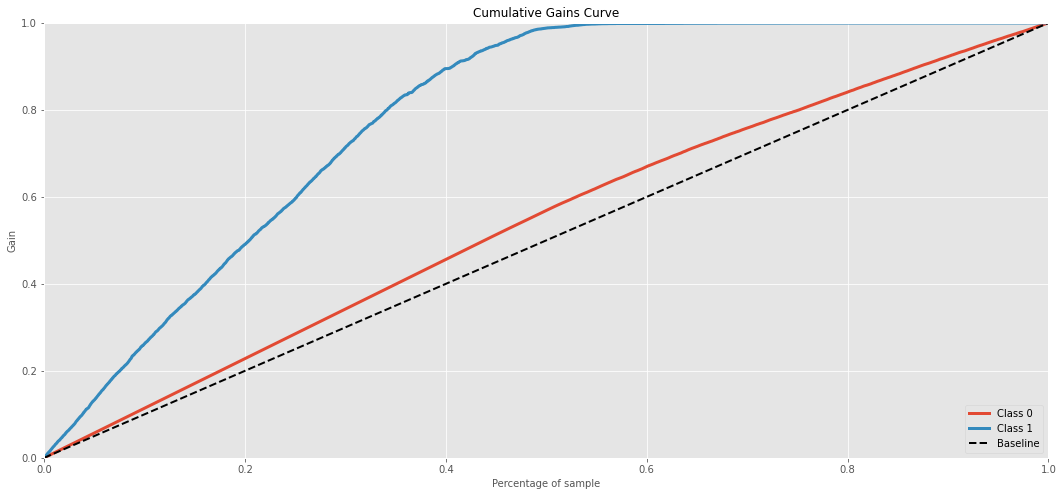

In [304]:
# Curva de ganho cumulativo
skplt.metrics.plot_cumulative_gain(y_test_fs, y_pred_xgb);

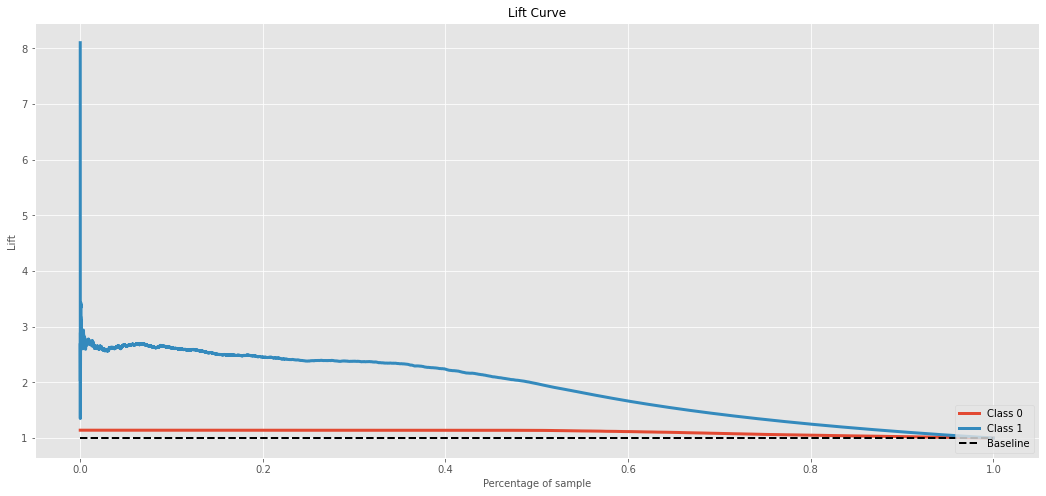

In [305]:
#Curva LIFT
skplt.metrics.plot_lift_curve(y_test_fs, y_pred_xgb);

In [306]:
df8 = X_test.copy()
df8['response'] = y_test.copy()

for e in lista:
    precision_k = precision(df8, y_pred_xgb, e)
    print(f'A precisão em top {e*100}% é: {round(precision_k, 2)}')

    recall_k = recall(df8, y_pred_xgb, e)
    print(f'O recall em top {e*100}% é: {round(recall_k, 2)}\n')

A precisão em top 30.0% é: 0.29
O recall em top 30.0% é: 0.71

A precisão em top 50.0% é: 0.24
O recall em top 50.0% é: 0.99

A precisão em top 70.0% é: 0.18
O recall em top 70.0% é: 1.0



### 8.5.1 - XGBoost com cross validation

In [307]:
df_xgb_cv = cross_validation('XGBoost', xgb_model, 3, X_train_fs, y_train_fs, 0.3)
df_xgb_cv

,model_name,Precision,Recall
0,XGBoost,mean: 0.32 | std: +/- 0.0,mean: 0.78 | std: +/- 0.0


## 8.6 - Avaliação final

In [308]:
resultado_cv = pd.concat([df_lr_cv, df_knn_cv, df_rf_cv, df_et_cv, df_xgb_cv])
resultado_cv.sort_values(['Precision', 'Recall'], ascending=False)

,model_name,Precision,Recall
0,XGBoost,mean: 0.32 | std: +/- 0.0,mean: 0.78 | std: +/- 0.0
0,Random Forest,mean: 0.3 | std: +/- 0.0,mean: 0.73 | std: +/- 0.0
0,Extra Tree,mean: 0.3 | std: +/- 0.0,mean: 0.73 | std: +/- 0.0
0,Logistic Regression,mean: 0.28 | std: +/- 0.0,mean: 0.68 | std: +/- 0.01
0,KNN,mean: 0.27 | std: +/- 0.0,mean: 0.67 | std: +/- 0.0


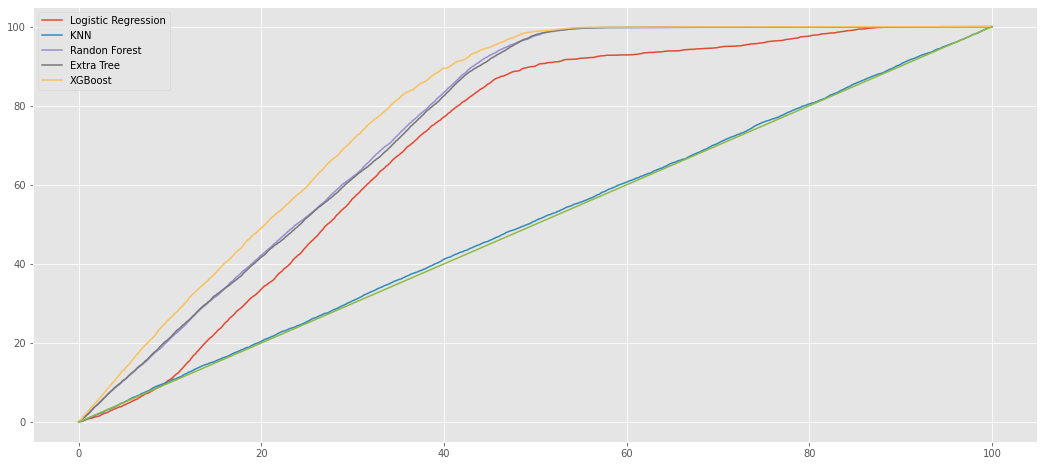

In [310]:
plt.plot(df_lr['base_percent'], df_lr['cumsum_percent'], label='Logistic Regression')
plt.plot(df_knn['base_percent'], df_knn['cumsum_percent'], label='KNN')
plt.plot(df_rf['base_percent'], df_rf['cumsum_percent'], label='Randon Forest')
plt.plot(df_et['base_percent'], df_et['cumsum_percent'], label='Extra Tree')
plt.plot(df_xgb['base_percent'], df_xgb['cumsum_percent'], label='XGBoost')

plt.plot(df_knn['base_percent'], df_knn['base_percent'])
plt.legend();

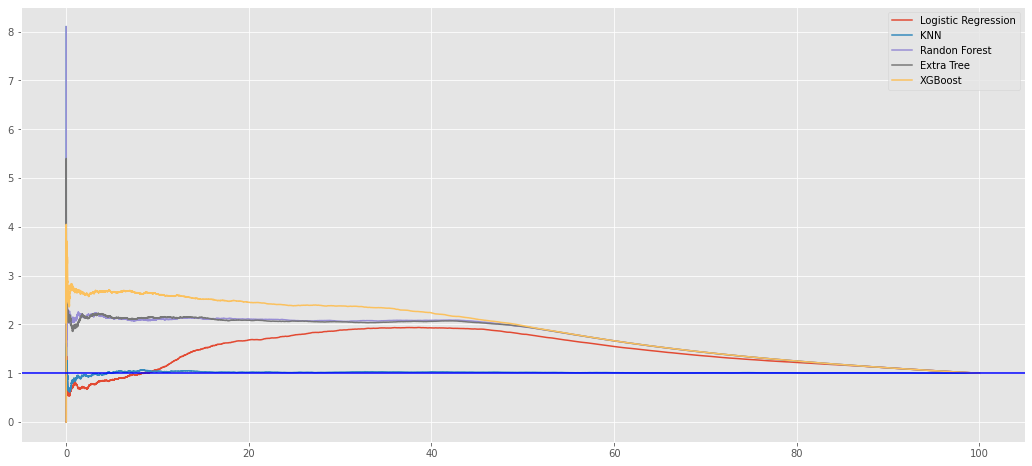

In [311]:
plt.plot(df_lr['base_percent'], df_lr['lift'], label='Logistic Regression')
plt.plot(df_knn['base_percent'], df_knn['lift'], label='KNN')
plt.plot(df_rf['base_percent'], df_rf['lift'], label='Randon Forest')
plt.plot(df_et['base_percent'], df_et['lift'], label='Extra Tree')
plt.plot(df_xgb['base_percent'], df_xgb['lift'], label='XGBoost')

plt.axhline(1,linestyle='-', color='blue')
plt.legend();

# 9 - Fine Tunning

## 9.1 - Random Search

In [112]:
param = {
'n_estimators': [120, 160, 250, 300],
'eta': [0.01, 0.03],
'max_depth': [3, 5, 10],
'subsample': [0.1, 0.5, 0.7],
'colsample_bytree': [0.3, 0.5, 0.7],
'min_child_weight': [1, 3, 8]
}

max_eval = 3

In [113]:
resultado_final = pd.DataFrame()

for i in range(max_eval):
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print(hp)

    # modelo
    xgb_model_tunned = XGBClassifier(n_estimators=hp['n_estimators'],
    eta=hp['eta'],
    max_depth=hp['max_depth'],
    subsample=hp['subsample'],
    colsample_bytree=hp['colsample_bytree'],
    min_child_weight=hp['min_child_weight'] )

    # perfomance
    resultado_xgb_cv = cross_validation('XGBoost', xgb_model_tunned, 3, X_train_fs, y_train_fs, 0.3)
    resultado_xgb_cv
    resultado_final = pd.concat( [resultado_final, resultado_xgb_cv] )
    
resultado_final

{'n_estimators': 160, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 3}
{'n_estimators': 300, 'eta': 0.01, 'max_depth': 10, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 1}
{'n_estimators': 120, 'eta': 0.03, 'max_depth': 10, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}


,model_name,Precision,Recall
0,XGBoost,mean: 0.32 | std: +/- 0.0,mean: 0.78 | std: +/- 0.0
0,XGBoost,mean: 0.3 | std: +/- 0.0,mean: 0.74 | std: +/- 0.0
0,XGBoost,mean: 0.32 | std: +/- 0.0,mean: 0.78 | std: +/- 0.0


## 9.2 - Modelo final

In [114]:
joblib.dump(xgb_model, '../models/xgb_model.joblib')

['../models/xgb_model.joblib']

# 10 - Perfomance do modelo

In [142]:
y_test_fs.shape

(60978,)

## 10.1 - Perfomance do modelo com 20 mil clientes

In [320]:
df_xgb[df_xgb['base'] == 20000]

,model_name,response,prediction,cumsum,cumsum_percent,base,base_percent,lift,precision,recall
26410,XGBoost,1,0.13998,5817,77.281786,20000,32.798714,2.356244,0.29085,0.772818


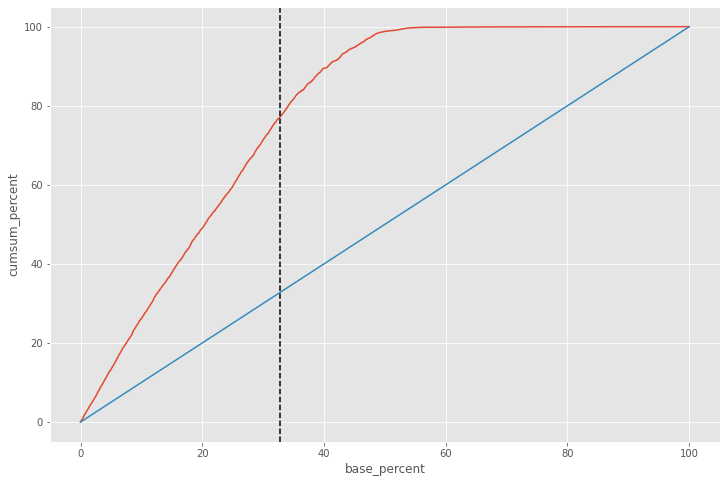

In [321]:
plt.figure( figsize=(12,8))
sns.lineplot(x='base_percent', y='cumsum_percent', data=df_xgb)
sns.lineplot(x='base_percent', y='base_percent', data=df_xgb)

plt.axvline(32.798714,linestyle='--', color='black');

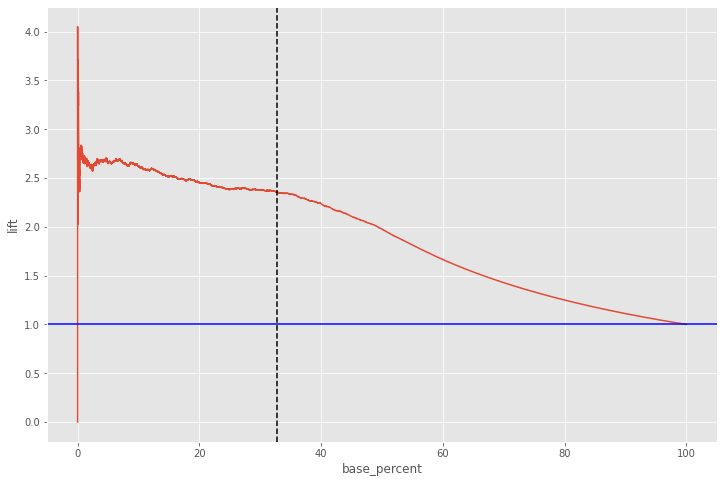

In [317]:
plt.figure( figsize=(12,8))
sns.lineplot(x='base_percent', y='lift', data=df_xgb)

plt.axvline(32.798714,linestyle='--', color='black')
plt.axhline(1,linestyle='-', color='blue');

## 10.2 - Perfomance do modelo com 30 mil clientes

In [313]:
df_xgb[df_xgb['base'] == 30000]

,model_name,response,prediction,cumsum,cumsum_percent,base,base_percent,lift,precision,recall
236409,XGBoost,0,0.025704,7419,98.565165,30000,49.198071,2.003436,0.2473,0.985652


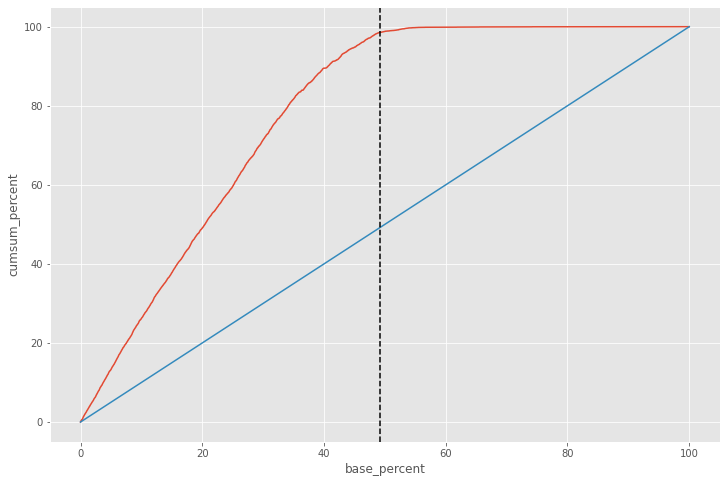

In [314]:
plt.figure( figsize=(12,8))
sns.lineplot(x='base_percent', y='cumsum_percent', data=df_xgb)
sns.lineplot(x='base_percent', y='base_percent', data=df_xgb)

plt.axvline(49.198071,linestyle='--', color='black');

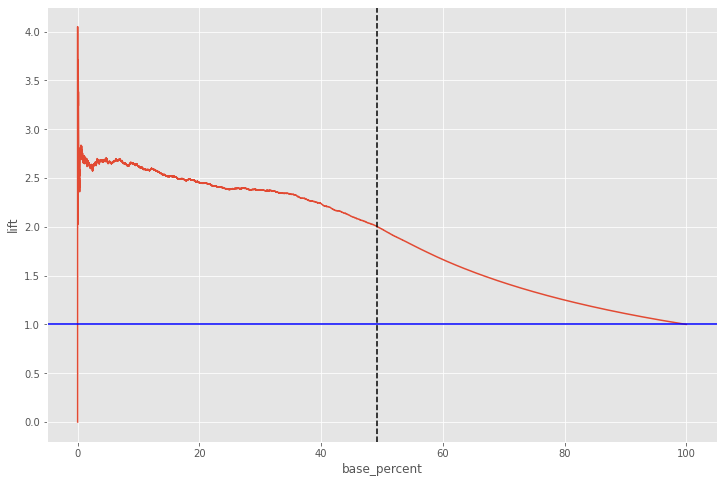

In [315]:
plt.figure( figsize=(12,8))
sns.lineplot(x='base_percent', y='lift', data=df_xgb)

plt.axvline(49.198071,linestyle='--', color='black')
plt.axhline(1,linestyle='-', color='blue');

# 11 - Deploy em produção

## 11.1 - Classe Health Insurance

In [1]:
import pandas as pd
import numpy as np
import joblib

class HealthInsurance:
    def __init__(self):
        self.home_path = '/mnt/c/users/jhonatan/desktop/comunidade_ds/repos/pa004_health_insurance_cross_sell/health_insurance_cross_sell/'
        self.fe_policy_sales_channel = joblib.load(self.home_path + 'scr/feature/fe_policy_sales_channel.joblib')
        self.mms_age = joblib.load(self.home_path + 'scr/feature/mms_age.joblib')
        self.mms_vintage = joblib.load(self.home_path + 'scr/feature/mms_vintage.joblib')
        self.ss_annual_premium = joblib.load(self.home_path + 'scr/feature/ss_annual_premium.joblib')
        self.target_encode_gender = joblib.load(self.home_path + 'scr/feature/target_encode_gender.joblib')
        self.target_encode_region_code = joblib.load(self.home_path + 'scr/feature/target_encode_region_code.joblib')
        
    def data_cleaning(self, data):
        # Renomear as colunas
        new_columns = []
        for e in data.columns:
            new_columns.append(e.lower())

        data.columns = new_columns
        
        return data
    
    def data_preparation(self, data):
        # Normalização
        data['annual_premium'] = self.ss_annual_premium.transform(data[['annual_premium']])
        
        # Rescaling
        data['vintage'] = self.mms_age.transform(data[['vintage']])
        data['vintage'] = self.mms_vintage.transform(data[['vintage']])
        
        # Encoding
        data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)
        data = pd.get_dummies( data, prefix='vehicle_age', columns=['vehicle_age'] )
        data.loc[:, 'gender'] = data['gender'].map(self.target_encode_gender)
        data.loc[:, 'region_code'] = data['region_code'].map(self.target_encode_region_code)
        data.loc[:, 'policy_sales_channel'] = data['policy_sales_channel'].map(self.fe_policy_sales_channel)
        
        # Seleção das colunas
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']
        
        return data[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # Predição do modelo
        pred = model.predict_proba(test_data)
        
        # Colocar os dados da predição nos dados originais
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records', date_format='iso')

## 11.2 - API Handler

In [2]:
import joblib
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

path = '/mnt/c/users/jhonatan/desktop/comunidade_ds/repos/pa004_health_insurance_cross_sell/health_insurance_cross_sell/'
model = joblib.load(path + 'models/xgb_model.joblib')

# Inicializando API
app = Flask(__name__)

@app.route('/healthinsurance/predict', methods=['POST'])
def healthinsurance_predict():
    test_json = request.get_json()
    if test_json: # Há dados
        if isinstance(test_json, dict): # Exemplo único
            test_raw = pd.DataFrame(test_json, columns=test_json[0])
        else: #Multiplos exemplos
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # Instanciando a classe HealthInsurance
        pipeline = HealthInsurance()
        
        # Data Cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # Data Preparation
        df2 = pipeline.data_preparation(df1)
        
        # Predição
        df_response = pipeline.get_prediction(model, test_raw, df2)
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run(debug=True)

ModuleNotFoundError: No module named 'healthinsurance'

## 11.3 - API Tester

In [119]:
import pandas as pd
import requests

In [150]:
df_test = pd.read_csv('../src/.data/test.csv')

In [151]:
data = json.dumps(df_test.to_dict(orient='records'))

In [152]:
# API call
# url = 'http://0.0.0.0:5000/healthinsurance/predict'
url = 'https://google-sheets-healthinsurance.herokuapp.com/healthinsurance/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data, headers=header)
print(f'Status code {r.status_code}')

Status code 200


In [153]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False )

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
88570,469680,Female,0.215385,1,11.0,0,1-2 Year,1,-0.544313,155.0,0.885813,0.475473
40385,421495,Male,0.261538,1,11.0,0,1-2 Year,1,-0.609031,155.0,0.671280,0.466041
93331,474441,Male,0.200000,1,41.0,0,< 1 Year,1,-0.607405,155.0,0.166090,0.465187
2812,383922,Male,0.215385,1,3.0,0,1-2 Year,1,-0.451999,155.0,0.453287,0.465187
13033,394143,Female,0.153846,1,11.0,0,1-2 Year,1,-0.396866,155.0,0.747405,0.462807
...,...,...,...,...,...,...,...,...,...,...,...,...
125326,506436,Male,0.846154,1,3.0,1,1-2 Year,0,0.032462,152.0,0.359862,0.000351
59762,440872,Male,0.846154,1,5.0,1,1-2 Year,0,-0.500509,152.0,0.166090,0.000343
2437,383547,Female,0.907692,1,8.0,1,1-2 Year,0,-0.153270,152.0,0.487889,0.000337
120657,501767,Male,0.815385,1,8.0,1,1-2 Year,0,-1.625418,152.0,0.858131,0.000336
